In [2]:
import numpy as np
import matplotlib.pyplot as plt
import nilearn
from nilearn import plotting
from nilearn import image
from nilearn.masking import apply_mask
import glob
import colorsys
from nilearn.masking import apply_mask
import pandas as pd
import itertools
import sys
from sklearn.utils import Bunch
import seaborn as sns


from statsmodels.stats.power import tt_ind_solve_power
from statsmodels.stats.power import tt_solve_power
from scipy.interpolate import interp1d
from nilearn import plotting
from nilearn import image
from nilearn.glm import threshold_stats_img

sys.path.append( sys.path.append('/home/marius/ownCloud/development/python/atlasreader/atlasreader') )
import atlasreader

import gm_analysis as gma
# from gm_analysis import subject
# from gm_analysis import info
# from gm_analysis import helpers as myHelpers

%matplotlib widget
plt.style.use('dark_background')

/home/marius/.virtualenvs/fmri/lib/python3.8/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


# Init subjects-dict

In [3]:
# init new dict if not existing
if 'subjects' not in locals():
    subjects = {}

sub_ses_list = {'sub-00': ['ses-gc', 'ses-com'], 'sub-0000':['ses-com', 'ses-sep']}

for sub_id in sub_ses_list:
    subjects[sub_id] = {}
    if not sub_ses_list[sub_id] == '':
        for ses_ in sub_ses_list[sub_id]:
            subjects[sub_id][ses_] = gma.subject.Subject(sub_id, ses_, gma.info.data_paths)
    else:
        subjects[sub_id] = gma.subject.Subject(sub_id, sub_ses_list[sub_id], gma.info.data_paths)


In [136]:
subjects['sub-00']['ses-com'].info.ROIs.functional['chGFP']

['/home/marius/ownCloud/PhD/projects/scientific/gaze-motion/analysis/gm_analysis/src/ROIs/individual/sub-00/functional/sub-00_task-co_Cubes1Cubes3-both_fwhm-5_p0.01-fpr_ROI-mask_chGFP-left.nii',
 '/home/marius/ownCloud/PhD/projects/scientific/gaze-motion/analysis/gm_analysis/src/ROIs/individual/sub-00/functional/sub-00_task-co_Cubes1Cubes3-both_fwhm-5_p0.05-fdr_ROI-mask_chGFP-right.nii']

In [ ]:
sub_id = 'sub-00'
ses_id = 'ses-ec'
_, _, left_mask, right_mask, img_name, left_distance_to_ref, right_distance_to_ref = subjects[sub_id][ses_id].compute_masks(
    task='MTloc',
    runs='run-1-2-3-4-5-6-7',
    con='MotionStatic',
    sign='positive',
    alpha=0.01,
    h_control='bonferroni',
    cluster_threshold=3,
    fwhm=5,
    ref_img='MTloc',
    use_lbls=False,
    plot_components=False,
    store=False)

plotting.plot_glass_brain(left_mask)
plotting.plot_glass_brain(right_mask)

In [ ]:
plt.close('all')

sub_id = 'sub-0000'
ses_id = 'ses-com'
_, _, left_mask, right_mask, img_name, left_distance_to_ref, right_distance_to_ref = subjects[sub_id][ses_id].compute_masks(
    task='gic',
    runs='run-1-2-3-4-5-6',
    con='CubesIris',
    sign='positive',
    alpha=0.0001,
    h_control='bonferroni',
    cluster_threshold=3,
    fwhm=5,
    ref_img='Marquardt2017',
    use_lbls=False,
    plot_components=False,
    store=False)

plotting.plot_glass_brain(left_mask)
plotting.plot_glass_brain(right_mask)

In [18]:
plt.close('all')

In [14]:
subjects[sub_id][ses_]

In [ ]:
subjects[sub_id][ses_][task_]

# Make dataframe

## BOLD values

In [3]:
# S = ['run-1', 'run-2', 'run-3', 'run-4', 'run-5', 'run-6']

# run_list = ['run-1-2-3',
# 'run-1-2-4',
# 'run-1-2-5',
# 'run-1-2-6',
# 'run-1-3-4',
# 'run-1-3-5',
# 'run-1-3-6',
# 'run-1-4-5',
# 'run-1-4-6',
# 'run-1-5-6',
# 'run-2-3-4',
# 'run-2-3-5',
# 'run-2-3-6',
# 'run-2-4-5',
# 'run-2-4-6',
# 'run-2-5-6',
# 'run-3-4-5',
# 'run-3-4-6',
# 'run-3-5-6',
# 'run-4-5-6']

In [ ]:
sub_task_dict[sub_id][ses_][task_]['runs']

In [6]:

data_collector = []

average_rois = True

sub_task_dict = {
    'sub-00': {
        'ses-gc': {
            'gc': {
                'conditions': ['Gaze', 'Cubes'], 
                'runs': ['run-1', 'run-2', 'run-3', 'run-4', 'run-5', 'run-6'],
                'subject_type': 'pilot'
            }
        },
        'ses-com': {
            'gic': {
                'conditions': ['Gaze', 'Cubes', 'Iris'], 
                'runs': ['run-1', 'run-2', 'run-3'],
                'subject_type': 'pilot'
            }
        }
    }, 
    'sub-0000': {
        'ses-com': { 
            'gic': { 
                'conditions': ['Gaze', 'Cubes', 'Iris'], 
                'runs': ['run-1', 'run-2', 'run-3', 'run-4', 'run-5', 'run-6'],
                'subject_type': 'pilot'
            }
        },
        'ses-sep': { 
            'co': { 
                'conditions': ['Cubes1', 'Cubes2', 'Cubes3'], 
                'runs': ['run-1', 'run-2', 'run-3'],
                'subject_type': 'pilot'
            },
            'go': { 
                'conditions': ['Gaze1', 'Gaze2', 'Gaze3'], 
                'runs': ['run-1', 'run-2', 'run-3'],
                'subject_type': 'pilot'
            }
        }
    }
}

fwhm = 'None' # None, 5
img_type = 'z-score'#'z_score', 'effect_size'

run_cntr = 0 # make nesting explicit

for sub_id in sub_task_dict.keys():
    print()
    print('***', sub_id)
    
    for ses_ in sub_task_dict[sub_id].keys():
        print('\t', ses_)
        
        for task_ in sub_task_dict[sub_id][ses_]:
            
            for run_ in sub_task_dict[sub_id][ses_][task_]['runs']:
                run_cntr += 1
                print('\t\t', run_cntr)
                    
                for cond in sub_task_dict[sub_id][ses_][task_]['conditions']:
                    print('\t\t\t', cond)

                    for roi_type in subjects[sub_id][ses_].info.ROIs:

                        if roi_type in ['functional', 'other']: 
                            
                            for roi_name in subjects[sub_id][ses_].info.ROIs[roi_type]:
                                # print('\t\t', roi_name)

                                for roi_img in subjects[sub_id][ses_].info.ROIs[roi_type][roi_name]:

                                    #
                                    if 'left' in roi_img:
                                        hemi_ = 'LH'
                                    elif 'right' in roi_img:
                                        hemi_ = 'RH'
                                    #

                                    # make sure nesting of runs is explicit
                                    if len(str(run_cntr)) == 1:
                                        run__ = run_[:-1]+'00'+str(run_cntr)
                                    elif len(str(run_cntr)) == 2:
                                        run__ = run_[:-1]+'0'+str(run_cntr)
                                    elif len(str(run_cntr)) == 3:
                                        run__ = run_[:-1]+str(run_cntr)

                                    map_ = [el for el in subjects[sub_id][ses_].univariate.results[task_][run_][cond]['fwhm-'+str(fwhm)] if img_type in el]
                                    roi_vals = apply_mask(map_, mask_img=roi_img)[0]
                                    
                                    # collect individual voxel values instead of averages
                                    if not average_rois:
                                        for vox_i, vox_val in enumerate(roi_vals):
                                            if vox_val == 0:
                                                print(sub_id, ses_, task_, run_, cond, roi_name, vox_i)
                                            data_collector.append([sub_id, sub_task_dict[sub_id][ses_][task_]['subject_type'], task_, run__, roi_name, hemi_, cond, vox_i, vox_val, 'beta_z-score'])
                                    
                                    # sub_id | subject_type | task1 | task2 | run1 | run2 | roi1 | roi2 | hemisphere | condition1 | condition2 | y | y_type 
                                    # data_collector.append([sub_id, sub_task_dict[sub_id][ses_][task_]['subject_type'], task_, np.NaN, run_, np.NaN, roi_name, np.NaN, hemi_, cond, np.NaN, value_[0], 'beta_z-score'])
                                    
                                    # sub_id | subject_type | task1 | run | roi | hemisphere | condition | y | y_type 
                                    if average_rois:
                                        value_ = np.mean(roi_vals)
                                        data_collector.append([sub_id, sub_task_dict[sub_id][ses_][task_]['subject_type'], task_, run__, roi_name, hemi_, cond, value_, 'beta_z-score'])



*** sub-00
	 ses-gc
		 1
			 Gaze
			 Cubes
		 2
			 Gaze
			 Cubes
		 3
			 Gaze
			 Cubes
		 4
			 Gaze
			 Cubes
		 5
			 Gaze
			 Cubes
		 6
			 Gaze
			 Cubes
	 ses-com
		 7
			 Gaze
			 Cubes
			 Iris
		 8
			 Gaze
			 Cubes
			 Iris
		 9
			 Gaze
			 Cubes
			 Iris

*** sub-0000
	 ses-com
		 10
			 Gaze
			 Cubes
			 Iris
		 11
			 Gaze
			 Cubes
			 Iris
		 12
			 Gaze
			 Cubes
			 Iris
		 13
			 Gaze
			 Cubes
			 Iris
		 14
			 Gaze
			 Cubes
			 Iris
		 15
			 Gaze
			 Cubes
			 Iris
	 ses-sep
		 16
			 Cubes1
			 Cubes2
			 Cubes3
		 17
			 Cubes1
			 Cubes2
			 Cubes3
		 18
			 Cubes1
			 Cubes2
			 Cubes3
		 19
			 Gaze1
			 Gaze2
			 Gaze3
		 20
			 Gaze1
			 Gaze2
			 Gaze3
		 21
			 Gaze1
			 Gaze2
			 Gaze3


In [16]:


# individual voxel values
df = pd.DataFrame(data_collector, columns=['participant', 'subject_type', 'task', 'run', 'roi', 'hemisphere', 'condition', 'voxel_id', 'y', 'type_of_y'])


# averaged across voxels
# df = pd.DataFrame(data_collector, columns=['participant', 'subject_type', 'task', 'run', 'roi', 'hemisphere', 'condition', 'y', 'type_of_y'])


In [17]:
df[
    (df.roi=='Marquardt-2017_GFP') &
    (df.condition=='Gaze1') & 
    (df.participant=='sub-0000') & 
    (df.hemisphere=='LH') & 
    (df.task=='go') 
]

participant subject_type task      run                 roi hemisphere  \
99025     sub-0000        pilot   go  run-019  Marquardt-2017_GFP         LH   
99026     sub-0000        pilot   go  run-019  Marquardt-2017_GFP         LH   
99027     sub-0000        pilot   go  run-019  Marquardt-2017_GFP         LH   
99028     sub-0000        pilot   go  run-019  Marquardt-2017_GFP         LH   
99029     sub-0000        pilot   go  run-019  Marquardt-2017_GFP         LH   
...            ...          ...  ...      ...                 ...        ...   
113226    sub-0000        pilot   go  run-021  Marquardt-2017_GFP         LH   
113227    sub-0000        pilot   go  run-021  Marquardt-2017_GFP         LH   
113228    sub-0000        pilot   go  run-021  Marquardt-2017_GFP         LH   
113229    sub-0000        pilot   go  run-021  Marquardt-2017_GFP         LH   
113230    sub-0000        pilot   go  run-021  Marquardt-2017_GFP         LH   

       condition  voxel_id         y     type_of_y  
99025      Gaze1         0  0.000000  beta_z-score  
99026      Gaze1         1  2.547176  beta_z-score  
99027      Gaze1         2  2.394149  beta_z-score  
99028      Gaze1         3  2.185441  beta_z-score  
99029      Gaze1         4  1.165043  beta_z-score  
...          ...       ...       ...           ...  
113226     Gaze1        71  1.528710  beta_z-score  
113227     Gaze1        72  1.759187  beta_z-score  
113228     Gaze1        73  1.153370  beta_z-score  
113229     Gaze1        74  0.923678  beta_z-score  
113230     Gaze1        75  0.696480  beta_z-score  

[228 rows x 10 columns]

In [13]:
df[
    (df.roi=='Marquardt-2017_GFP') &
    (df.condition=='Gaze3') & 
    (df.participant=='sub-0000') & 
    (df.hemisphere=='LH') & 
    (df.task=='go') 
]

participant subject_type task      run                 roi hemisphere  \
913     sub-0000        pilot   go  run-019  Marquardt-2017_GFP         LH   
973     sub-0000        pilot   go  run-020  Marquardt-2017_GFP         LH   
1033    sub-0000        pilot   go  run-021  Marquardt-2017_GFP         LH   

     condition         y     type_of_y  
913      Gaze3  0.917046  beta_z-score  
973      Gaze3  1.485103  beta_z-score  
1033     Gaze3  1.459900  beta_z-score

In [18]:
fp = '/home/marius/ownCloud/PhD/projects/scientific/gaze-motion/results/mixed_models/data_tables/gm-dat_fwhm-5_z-scores_ivox.csv'
df.to_csv(fp, sep='\t', index=False)

In [39]:
data_collector[0]

['sub-00',
 'pilot',
 'gc',
 'run-1',
 'GazeCubes',
 'LH',
 'Gaze',
 0.27230048,
 'beta_z-score']

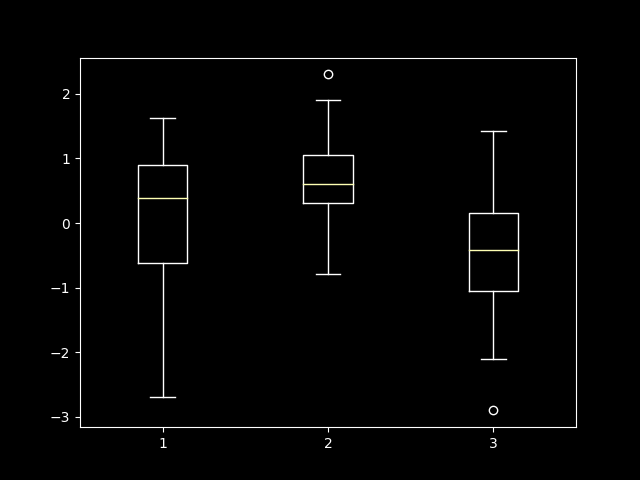

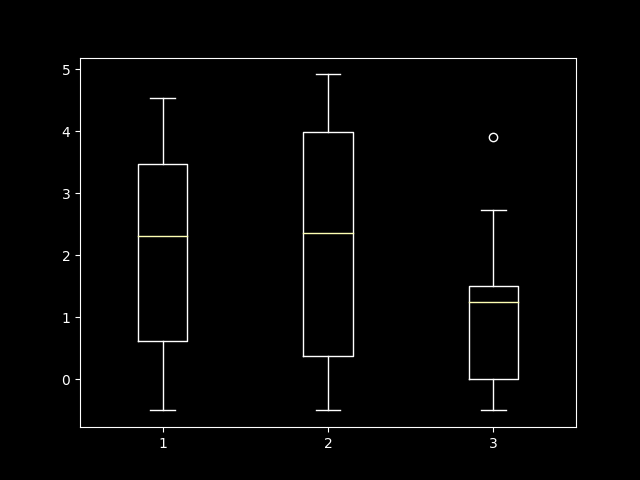

In [47]:
hemi_ = 'LH'
roi_ = 'gGFP'

plt.figure()
plt.boxplot(
    [[el[7] for el in data_collector if el[6] == 'Gaze' and el[5]==hemi_ and el[4] == roi_],
    [el[7] for el in data_collector if el[6] == 'Cubes' and el[5]==hemi_ and el[4] == roi_],
    [el[7] for el in data_collector if el[6] == 'Iris' and el[5]==hemi_ and el[4] == roi_]])
plt.show()

hemi_ = 'RH'
roi_ = 'gGFP'

plt.figure()
plt.boxplot(
    [[el[7] for el in data_collector if el[6] == 'Gaze' and el[5]==hemi_ and el[4] == roi_],
    [el[7] for el in data_collector if el[6] == 'Cubes' and el[5]==hemi_ and el[4] == roi_],
    [el[7] for el in data_collector if el[6] == 'Iris' and el[5]==hemi_ and el[4] == roi_]])
plt.show()

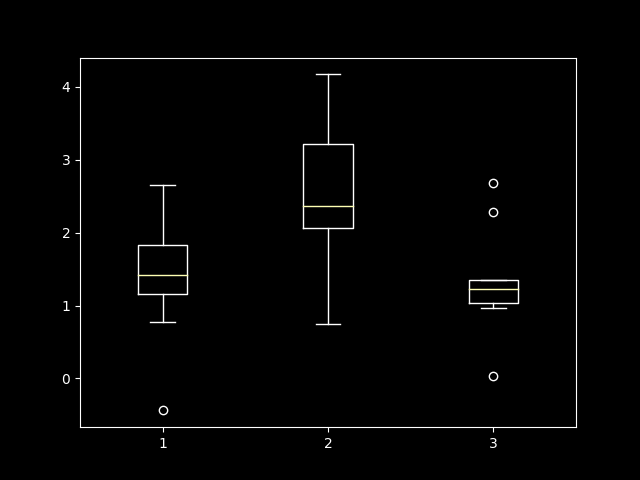

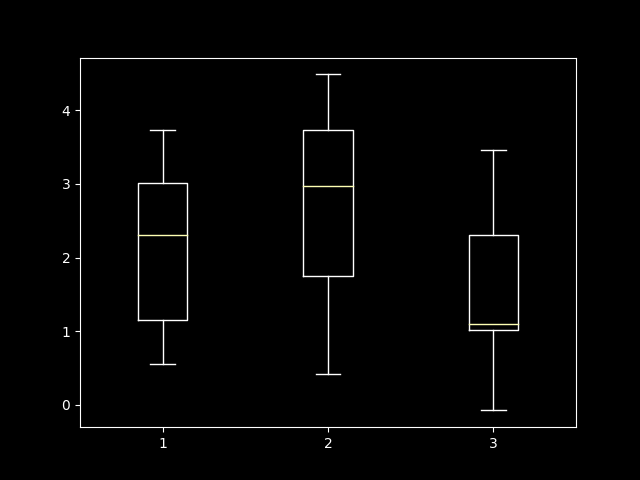

In [46]:
hemi_ = 'LH'
roi_ = 'fMotionArea'

plt.figure()
plt.boxplot(
    [[el[7] for el in data_collector if el[6] == 'Gaze' and el[5]==hemi_ and el[4] == roi_],
    [el[7] for el in data_collector if el[6] == 'Cubes' and el[5]==hemi_ and el[4] == roi_],
    [el[7] for el in data_collector if el[6] == 'Iris' and el[5]==hemi_ and el[4] == roi_]])
plt.show()

hemi_ = 'RH'
roi_ = 'fMotionArea'

plt.figure()
plt.boxplot(
    [[el[7] for el in data_collector if el[6] == 'Gaze' and el[5]==hemi_ and el[4] == roi_],
    [el[7] for el in data_collector if el[6] == 'Cubes' and el[5]==hemi_ and el[4] == roi_],
    [el[7] for el in data_collector if el[6] == 'Iris' and el[5]==hemi_ and el[4] == roi_]])
plt.show()

## Local maxima

### testing

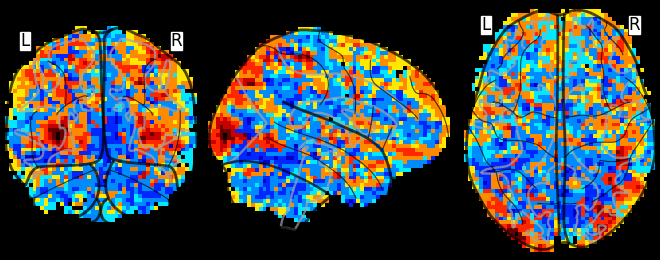

(-54.5, -69.5, 8.5) (47.5, -66.5, 5.5)


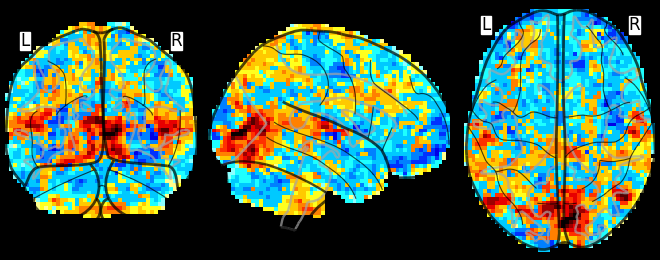

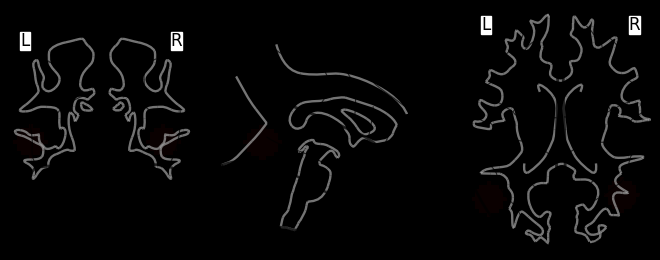

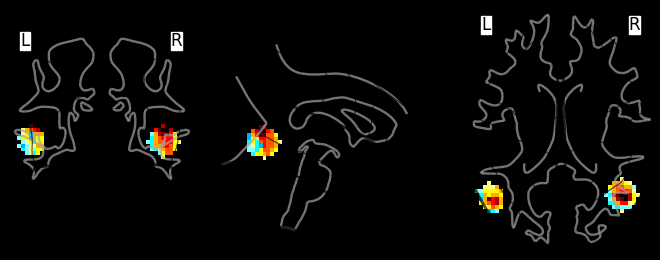

In [40]:
plt.close('all')

nii_img = image.load_img([el for el in subjects['sub-00']['ses-gc'].univariate.results['gc']['run-2']['Cubes']['fwhm-5'] if 'z-score' in el][0])
# nii_img, _ = threshold_stats_img(nii_img, alpha=0.01, height_control='fpr', cluster_threshold=3)
plotting.plot_glass_brain(nii_img, plot_abs=False)

# 'Marquardt2017': [[-54, -67, -3],[50, -64, -3]]
left_ref_coordinate_mni = [-54, -67, -3]
left_ref_coordinate_ijk = image.coord_transform(left_ref_coordinate_mni[0], left_ref_coordinate_mni[1], left_ref_coordinate_mni[2], np.linalg.inv(nii_img.affine))
left_ref_coordinate_ijk = tuple(map(int, left_ref_coordinate_ijk))
right_ref_coordinate_mni = [50, -64, -3]
right_ref_coordinate_ijk = image.coord_transform(right_ref_coordinate_mni[0], right_ref_coordinate_mni[1], right_ref_coordinate_mni[2], np.linalg.inv(nii_img.affine))
right_ref_coordinate_ijk = tuple(map(int, right_ref_coordinate_ijk))

# make the spheres
left_sphere_arr = gma.helpers.sphere(np.shape(nii_img), 4, left_ref_coordinate_ijk)
right_sphere_arr = gma.helpers.sphere(np.shape(nii_img), 4, right_ref_coordinate_ijk)
mask_arr = left_sphere_arr + right_sphere_arr

# plot the mask
mask_img = image.new_img_like(nii_img, mask_arr)
plotting.plot_glass_brain(mask_img, plot_abs=False)

# mask the image
img_arr = nii_img.get_fdata()
img_arr_masked = img_arr.copy()
img_arr_masked[np.invert(mask_arr)] = 0
nii_img_masked = image.new_img_like(nii_img, img_arr_masked)
plotting.plot_glass_brain(nii_img_masked, plot_abs=False)

# get argmax
img_arr_masked_left = img_arr.copy()
img_arr_masked_left[np.invert(left_sphere_arr)] = 0
img_arr_masked_right = img_arr.copy()
img_arr_masked_right[np.invert(right_sphere_arr)] = 0
left_argmax_ijk = np.unravel_index(np.argmax(img_arr_masked_left), np.shape(img_arr_masked_left))
left_argmax_mni = image.coord_transform(left_argmax_ijk[0], left_argmax_ijk[1], left_argmax_ijk[2], nii_img.affine)
right_argmax_ijk = np.unravel_index(np.argmax(img_arr_masked_right), np.shape(img_arr_masked_right))
right_argmax_mni = image.coord_transform(right_argmax_ijk[0], right_argmax_ijk[1], right_argmax_ijk[2], nii_img.affine)

print(left_argmax_mni, right_argmax_mni)


### Run peak identification

In [23]:
plt.close('all')

In [27]:
[
    np.argmax(
        [np.abs(-5), np.abs(-2)]), np.argmax([np.abs(-3), np.abs(4)])]

[0, 1]

In [17]:
### choose the mximum activation with the ROI, independent of sign

sphere_size = 4
store_as_ = 'long' # wide or long table format

data_collector = []

sub_task_dict = {
    'sub-00': {
        'ses-gc': {
            'gc': {
                'GazeCubes':{
                    'runs': ['run-1', 'run-2', 'run-3', 'run-4', 'run-5', 'run-6'],
                    'r_complete': 'run-1-2-3-4-5-6',
                    'subject_type': 'pilot'
                }
            },
            'MTloc': {
                'MotionStatic':{
                    'runs': ['run-1', 'run-2', 'run-3', 'run-4', 'run-5', 'run-6', 'run-7'],
                    'r_complete': 'run-1-2-3-4-5-6',
                    'subject_type': 'pilot'
                }
            }
        },
        'ses-com': {
            'gic': {
                'Gaze1Iris123': { 
                    'runs': ['run-1', 'run-2', 'run-3'],
                    'r_complete': 'run-1-2-3',
                    'subject_type': 'pilot'
                },
                'Gaze1Cubes123': { 
                    'runs': ['run-1', 'run-2', 'run-3'],
                    'r_complete': 'run-1-2-3',
                    'subject_type': 'pilot'
                },
                'CubesIris': { 
                    'runs': ['run-1', 'run-2', 'run-3'],
                    'r_complete': 'run-1-2-3',
                    'subject_type': 'pilot'
                }
            }
        }
    }, 
    'sub-0000': {
        'ses-com': { 
            'gic': { 
                'GazeIris': {
                    'runs': ['run-1', 'run-2', 'run-3', 'run-4', 'run-5', 'run-6'],
                    'r_complete': 'run-1-2-3-4-5-6',
                    'subject_type': 'pilot'
                },
                'GazeCubes': {
                    'runs': ['run-1', 'run-2', 'run-3', 'run-4', 'run-5', 'run-6'],
                    'r_complete': 'run-1-2-3-4-5-6',
                    'subject_type': 'pilot'
                },
                'CubesIris': {
                    'runs': ['run-1', 'run-2', 'run-3', 'run-4', 'run-5', 'run-6'],
                    'r_complete': 'run-1-2-3-4-5-6',
                    'subject_type': 'pilot'
                }
            },
            'MTloc': { 
                'MotionStatic': {
                    'runs': ['run-1', 'run-2', 'run-3', 'run-4', 'run-5', 'run-6'],
                    'r_complete': 'run-1-2-3-4-5-6',
                    'subject_type': 'pilot'
                }
            }
        },
        'ses-sep': { 
            'co': { 
                'Cubes1Cubes3': { 
                    'runs': ['run-1', 'run-2', 'run-3'],
                    'r_complete': 'run-1-2-3',
                    'subject_type': 'pilot'
                }
            },
            'go': { 
                'Gaze1Gaze3': { 
                    'runs': ['run-1', 'run-2', 'run-3'],
                    'r_complete': 'run-1-2-3',
                    'subject_type': 'pilot'
                }
            }
        }
    }
}

fwhm = '5'
img_type = 'z-score'#'z_score', 'effect_size'
references = {'visual_motion': [[-46, -70, 2], [44, -68, 2]], 'Marquardt2017': [[-54, -67, -3],[50, -64, -3]]}
# peaks_dict = {'participant': [], 'task': [], 'contrast': [], 'sign': [], 'run': [], 'hemisphere': [], 'x': [], 'y': [], 'z':[]}
if store_as_ == 'long':
    peaks_dict = {'participant': [], 'task': [], 'contrast': [], 'sign': [], 'run': [], 'hemisphere': [], 'dimension': [], 'value': [], 'dist_to_ref': [], 'reference': []}
elif store_as_ == 'wide':
    peaks_dict = {'participant': [], 'task': [], 'contrast': [], 'sign': [], 'run': [], 'hemisphere': [], 'coordinate': [], 'dist_to_ref': [], 'reference': []}


for sub_id in sub_task_dict.keys():
    print()
    print('***', sub_id)
        
    for ses_ in sub_task_dict[sub_id].keys():
        print('\t', ses_)
        
        for task_ in sub_task_dict[sub_id][ses_]:
                
            for ref_ in references:
                print('\t\t', ref_)
                
                for con_ in sub_task_dict[sub_id][ses_][task_]:
                    print('\t\t\t', con_)

                    for run_ in sub_task_dict[sub_id][ses_][task_][con_]['runs']:

                        nii_img = image.load_img([el for el in subjects[sub_id][ses_].univariate.results[task_][run_][con_]['fwhm-'+str(fwhm)] if img_type in el][0])
                        # nii_img, _ = threshold_stats_img(nii_img, alpha=0.01, height_control='fpr', cluster_threshold=3)
                        img_arr = nii_img.get_fdata()

                        # get the reference coordinates
                        left_ref_coordinate_ijk = image.coord_transform(
                            references[ref_][0][0], 
                            references[ref_][0][1], 
                            references[ref_][0][2], 
                            np.linalg.inv(nii_img.affine))
                        right_ref_coordinate_ijk = image.coord_transform(
                            references[ref_][1][0], 
                            references[ref_][1][1], 
                            references[ref_][1][2], 
                            np.linalg.inv(nii_img.affine))
                        left_ref_coordinate_ijk = tuple(map(int, left_ref_coordinate_ijk))
                        right_ref_coordinate_ijk = tuple(map(int, right_ref_coordinate_ijk))

                        # make the spheres around reference coordinates
                        left_sphere_arr = gma.helpers.sphere(np.shape(nii_img), sphere_size, left_ref_coordinate_ijk)
                        right_sphere_arr = gma.helpers.sphere(np.shape(nii_img), sphere_size, right_ref_coordinate_ijk)


                        # get argmax/ argmin
                        img_arr_masked_left = img_arr.copy()
                        img_arr_masked_left[np.invert(left_sphere_arr)] = 0
                        img_arr_masked_right = img_arr.copy()
                        img_arr_masked_right[np.invert(right_sphere_arr)] = 0
                        #
                        left_argmax_ijk = np.unravel_index(np.argmax(img_arr_masked_left), np.shape(img_arr_masked_left))
                        left_max_value = img_arr_masked_left[left_argmax_ijk]
                        left_argmax_mni = image.coord_transform(left_argmax_ijk[0], left_argmax_ijk[1], left_argmax_ijk[2], nii_img.affine)
                        right_argmax_ijk = np.unravel_index(np.argmax(img_arr_masked_right), np.shape(img_arr_masked_right))
                        right_max_value = img_arr_masked_right[right_argmax_ijk]
                        right_argmax_mni = image.coord_transform(right_argmax_ijk[0], right_argmax_ijk[1], right_argmax_ijk[2], nii_img.affine)

                        left_argmin_ijk = np.unravel_index(np.argmin(img_arr_masked_left), np.shape(img_arr_masked_left))
                        left_min_value = img_arr_masked_left[left_argmin_ijk]
                        left_argmin_mni = image.coord_transform(left_argmin_ijk[0], left_argmin_ijk[1], left_argmin_ijk[2], nii_img.affine)
                        right_argmin_ijk = np.unravel_index(np.argmin(img_arr_masked_right), np.shape(img_arr_masked_right))
                        right_min_value = img_arr_masked_right[right_argmin_ijk]
                        right_argmin_mni = image.coord_transform(right_argmin_ijk[0], right_argmin_ijk[1], right_argmin_ijk[2], nii_img.affine)

                        peak_coordinate_collection = [[left_argmin_mni, left_argmax_mni], [right_argmin_mni, right_argmax_mni]]
                        peak_value_collection = [[left_min_value, left_max_value], [right_min_value, right_max_value]]
                        peak_value_sign_collection = [[np.sign(left_min_value), np.sign(left_max_value)], [np.sign(right_min_value), np.sign(right_max_value)]]

                        max_ids = [np.argmax([np.abs(left_min_value), np.abs(left_max_value)]), np.argmax([np.abs(right_min_value), np.abs(right_max_value)])]

                        peak_coordinates = [peak_coordinate_collection[0][max_ids[0]], peak_coordinate_collection[1][max_ids[1]]] # [LEFT_COORDINATE, RIGHT_COORDINATE]
                        peak_values = [peak_value_collection[0][max_ids[0]], peak_value_collection[1][max_ids[1]]] 
                        peak_signs = [peak_value_sign_collection[0][max_ids[0]], peak_value_sign_collection[1][max_ids[1]]] 


                        print('\t\t\t\t\t', peak_coordinates, peak_values, peak_signs)

                        if store_as_ == 'long':
                            for ih_,hemi_ in enumerate(['left', 'right']):
                                for id_, dim_ in enumerate(['x', 'y', 'z']):
                                    peaks_dict['participant'].append(sub_id)
                                    peaks_dict['task'].append(task_)
                                    peaks_dict['contrast'].append(con_)
                                    peaks_dict['sign'].append(peak_signs[ih_])
                                    peaks_dict['run'].append(run_)
                                    peaks_dict['hemisphere'].append(hemi_)
                                    peaks_dict['dimension'].append(dim_)
                                    peaks_dict['value'].append(peak_coordinates[ih_][id_])
                                    peaks_dict['dist_to_ref'].append(np.linalg.norm(np.array(peak_coordinates[ih_]) - np.array(references[ref_][ih_])))
                                    peaks_dict['reference'].append(ref_)

                        elif store_as_ == 'wide':
                            for ih_,hemi_ in enumerate(['left', 'right']):
                                    peaks_dict['participant'].append(sub_id)
                                    peaks_dict['task'].append(task_)
                                    peaks_dict['contrast'].append(con_)
                                    peaks_dict['sign'].append(peak_signs[ih_])
                                    peaks_dict['run'].append(run_)
                                    peaks_dict['hemisphere'].append(hemi_)
                                    peaks_dict['coordinate'].append(peak_coordinates[ih_])
                                    peaks_dict['dist_to_ref'].append(np.linalg.norm(np.array(peak_coordinates[ih_]) - np.array(references[ref_][ih_])))
                                    peaks_dict['reference'].append(ref_)



                        
peaks_df = pd.DataFrame(peaks_dict)



*** sub-00
	 ses-gc
		 visual_motion
			 GazeCubes
					 [(-57.5, -69.5, 5.5), (44.5, -60.5, -3.5)] [-8.0, -5.0] [-1.0, -1.0]
					 [(-54.5, -75.5, 8.5), (47.5, -66.5, -3.5)] [-9.0, -5.0] [-1.0, -1.0]
					 [(-54.5, -63.5, 2.5), (35.5, -78.5, -0.5)] [-7.0, -4.0] [-1.0, -1.0]
					 [(-51.5, -75.5, 5.5), (44.5, -60.5, -0.5)] [-5.0, -6.0] [-1.0, -1.0]
					 [(-48.5, -69.5, 5.5), (41.5, -78.5, 5.5)] [-8.0, -4.0] [-1.0, -1.0]
					 [(-54.5, -72.5, 8.5), (47.5, -66.5, 8.5)] [-7.0, -4.0] [-1.0, -1.0]
		 Marquardt2017
			 GazeCubes
					 [(-57.5, -69.5, 5.5), (44.5, -60.5, -3.5)] [-8.0, -5.0] [-1.0, -1.0]
					 [(-54.5, -69.5, 8.5), (41.5, -57.5, -6.5)] [-8.0, -5.0] [-1.0, -1.0]
					 [(-54.5, -63.5, 2.5), (41.5, -75.5, -0.5)] [-7.0, -4.0] [-1.0, -1.0]
					 [(-51.5, -75.5, 5.5), (44.5, -60.5, -0.5)] [-5.0, -6.0] [-1.0, -1.0]
					 [(-48.5, -69.5, 5.5), (38.5, -63.5, -9.5)] [-8.0, 3.0] [-1.0, 1.0]
					 [(-54.5, -69.5, 8.5), (47.5, -66.5, 8.5)] [-6.0, -4.0] [-1.0, -1.0]
		 visual_motion
			 M

In [7]:
# sphere_size = 4
# store_as_ = 'long' # wide or long table format

# data_collector = []

# sub_task_dict = {
#     'sub-00': {
#         'ses-gc': {
#             'gc': {
#                 'GazeCubes':{
#                     'runs': ['run-1', 'run-2', 'run-3', 'run-4', 'run-5', 'run-6'],
#                     'r_complete': 'run-1-2-3-4-5-6',
#                     'subject_type': 'pilot'
#                 }
#             },
#             'MTloc': {
#                 'MotionStatic':{
#                     'runs': ['run-1', 'run-2', 'run-3', 'run-4', 'run-5', 'run-6', 'run-7'],
#                     'r_complete': 'run-1-2-3-4-5-6',
#                     'subject_type': 'pilot'
#                 }
#             }
#         },
#         'ses-com': {
#             'gic': {
#                 'Gaze1Iris123': { 
#                     'runs': ['run-1', 'run-2', 'run-3'],
#                     'r_complete': 'run-1-2-3',
#                     'subject_type': 'pilot'
#                 },
#                 'Gaze1Cubes123': { 
#                     'runs': ['run-1', 'run-2', 'run-3'],
#                     'r_complete': 'run-1-2-3',
#                     'subject_type': 'pilot'
#                 },
#                 'CubesIris': { 
#                     'runs': ['run-1', 'run-2', 'run-3'],
#                     'r_complete': 'run-1-2-3',
#                     'subject_type': 'pilot'
#                 }
#             }
#         }
#     }, 
#     'sub-0000': {
#         'ses-com': { 
#             'gic': { 
#                 'GazeIris': {
#                     'runs': ['run-1', 'run-2', 'run-3', 'run-4', 'run-5', 'run-6'],
#                     'r_complete': 'run-1-2-3-4-5-6',
#                     'subject_type': 'pilot'
#                 },
#                 'GazeCubes': {
#                     'runs': ['run-1', 'run-2', 'run-3', 'run-4', 'run-5', 'run-6'],
#                     'r_complete': 'run-1-2-3-4-5-6',
#                     'subject_type': 'pilot'
#                 },
#                 'CubesIris': {
#                     'runs': ['run-1', 'run-2', 'run-3', 'run-4', 'run-5', 'run-6'],
#                     'r_complete': 'run-1-2-3-4-5-6',
#                     'subject_type': 'pilot'
#                 }
#             },
#             'MTloc': { 
#                 'MotionStatic': {
#                     'runs': ['run-1', 'run-2', 'run-3', 'run-4', 'run-5', 'run-6'],
#                     'r_complete': 'run-1-2-3-4-5-6',
#                     'subject_type': 'pilot'
#                 }
#             }
#         },
#         'ses-sep': { 
#             'co': { 
#                 'Cubes1Cubes3': { 
#                     'runs': ['run-1', 'run-2', 'run-3'],
#                     'r_complete': 'run-1-2-3',
#                     'subject_type': 'pilot'
#                 }
#             },
#             'go': { 
#                 'Gaze1Gaze3': { 
#                     'runs': ['run-1', 'run-2', 'run-3'],
#                     'r_complete': 'run-1-2-3',
#                     'subject_type': 'pilot'
#                 }
#             }
#         }
#     }
# }

# fwhm = 'None'
# img_type = 'z-score'#'z_score', 'effect_size'
# references = {'visual_motion': [[-46, -70, 2], [44, -68, 2]], 'Marquardt2017': [[-54, -67, -3],[50, -64, -3]]}
# # peaks_dict = {'participant': [], 'task': [], 'contrast': [], 'sign': [], 'run': [], 'hemisphere': [], 'x': [], 'y': [], 'z':[]}
# if store_as_ == 'long':
#     peaks_dict = {'participant': [], 'task': [], 'contrast': [], 'sign': [], 'run': [], 'hemisphere': [], 'dimension': [], 'value': [], 'dist_to_ref': [], 'reference': []}
# elif store_as_ == 'wide':
#     peaks_dict = {'participant': [], 'task': [], 'contrast': [], 'sign': [], 'run': [], 'hemisphere': [], 'coordinate': [], 'dist_to_ref': [], 'reference': []}


# for sub_id in sub_task_dict.keys():
#     print()
#     print('***', sub_id)
        
#     for ses_ in sub_task_dict[sub_id].keys():
#         print('\t', ses_)
        
#         for task_ in sub_task_dict[sub_id][ses_]:
                
#             for ref_ in references:
                
#                 for con_ in sub_task_dict[sub_id][ses_][task_]:
#                     print('\t\t', con_)

#                     for sign_ in ['positive', 'negative']:

#                         if sign_ == 'positive':

#                             for run_ in sub_task_dict[sub_id][ses_][task_][con_]['runs']:

#                                 nii_img = image.load_img([el for el in subjects[sub_id][ses_].univariate.results[task_][run_][con_]['fwhm-'+str(fwhm)] if img_type in el][0])
#                                 nii_img, _ = threshold_stats_img(nii_img, alpha=0.01, height_control='fpr', cluster_threshold=3)
#                                 img_arr = nii_img.get_fdata()
                                
#                                 # get the reference coordinates
#                                 left_ref_coordinate_ijk = image.coord_transform(
#                                     references[ref_][0][0], 
#                                     references[ref_][0][1], 
#                                     references[ref_][0][2], 
#                                     np.linalg.inv(nii_img.affine))
#                                 right_ref_coordinate_ijk = image.coord_transform(
#                                     references[ref_][1][0], 
#                                     references[ref_][1][1], 
#                                     references[ref_][1][2], 
#                                     np.linalg.inv(nii_img.affine))
#                                 left_ref_coordinate_ijk = tuple(map(int, left_ref_coordinate_ijk))
#                                 right_ref_coordinate_ijk = tuple(map(int, right_ref_coordinate_ijk))
                            
#                                 # make the spheres around reference coordinates
#                                 left_sphere_arr = gma.helpers.sphere(np.shape(nii_img), sphere_size, left_ref_coordinate_ijk)
#                                 right_sphere_arr = gma.helpers.sphere(np.shape(nii_img), sphere_size, right_ref_coordinate_ijk)
                                
                                
#                                 # get argmax
#                                 img_arr_masked_left = img_arr.copy()
#                                 img_arr_masked_left[np.invert(left_sphere_arr)] = 0
#                                 img_arr_masked_right = img_arr.copy()
#                                 img_arr_masked_right[np.invert(right_sphere_arr)] = 0
#                                 left_argmax_ijk = np.unravel_index(np.argmax(img_arr_masked_left), np.shape(img_arr_masked_left))
#                                 left_argmax_mni = image.coord_transform(left_argmax_ijk[0], left_argmax_ijk[1], left_argmax_ijk[2], nii_img.affine)
#                                 right_argmax_ijk = np.unravel_index(np.argmax(img_arr_masked_right), np.shape(img_arr_masked_right))
#                                 right_argmax_mni = image.coord_transform(right_argmax_ijk[0], right_argmax_ijk[1], right_argmax_ijk[2], nii_img.affine)
#                                 argmax_mni = [left_argmax_mni, right_argmax_mni]

#                                 print('\t\t\t\t', argmax_mni)

#                                 if store_as_ == 'long':
#                                     for ih_,hemi_ in enumerate(['left', 'right']):
#                                         for id_, dim_ in enumerate(['x', 'y', 'z']):
#                                             peaks_dict['participant'].append(sub_id)
#                                             peaks_dict['task'].append(task_)
#                                             peaks_dict['contrast'].append(con_)
#                                             peaks_dict['sign'].append(sign_)
#                                             peaks_dict['run'].append(run_)
#                                             peaks_dict['hemisphere'].append(hemi_)
#                                             peaks_dict['dimension'].append(dim_)
#                                             peaks_dict['value'].append(argmax_mni[ih_][id_])
#                                             peaks_dict['dist_to_ref'].append(np.linalg.norm(np.array(argmax_mni[ih_]) - np.array(references[ref_][ih_])))
#                                             peaks_dict['reference'].append(ref_)
                                            
#                                 elif store_as_ == 'wide':
#                                     for ih_,hemi_ in enumerate(['left', 'right']):
#                                             peaks_dict['participant'].append(sub_id)
#                                             peaks_dict['task'].append(task_)
#                                             peaks_dict['contrast'].append(con_)
#                                             peaks_dict['sign'].append(sign_)
#                                             peaks_dict['run'].append(run_)
#                                             peaks_dict['hemisphere'].append(hemi_)
#                                             peaks_dict['coordinate'].append(argmax_mni[ih_])
#                                             peaks_dict['dist_to_ref'].append(np.linalg.norm(np.array(argmax_mni[ih_]) - np.array(references[ref_][ih_])))
#                                             peaks_dict['reference'].append(ref_)



#                         elif sign_ == 'negative':

#                             for run_ in sub_task_dict[sub_id][ses_][task_][con_]['runs']:

#                                 nii_img = image.load_img([el for el in subjects[sub_id][ses_].univariate.results[task_][run_][con_]['fwhm-'+str(fwhm)] if img_type in el][0])
#                                 nii_img, _ = threshold_stats_img(nii_img, alpha=0.01, height_control='fpr', cluster_threshold=3)
#                                 img_arr = nii_img.get_fdata()
                                
                                
#                                 # get the reference coordinates
#                                 left_ref_coordinate_ijk = image.coord_transform(
#                                     references[ref_][0][0], 
#                                     references[ref_][0][1], 
#                                     references[ref_][0][2], 
#                                     np.linalg.inv(nii_img.affine))
#                                 right_ref_coordinate_ijk = image.coord_transform(
#                                     references[ref_][1][0], 
#                                     references[ref_][1][1], 
#                                     references[ref_][1][2], 
#                                     np.linalg.inv(nii_img.affine))
#                                 left_ref_coordinate_ijk = tuple(map(int, left_ref_coordinate_ijk))
#                                 right_ref_coordinate_ijk = tuple(map(int, right_ref_coordinate_ijk))
                            
#                                 # make the spheres around reference coordinates
#                                 left_sphere_arr = gma.helpers.sphere(np.shape(nii_img), sphere_size, left_ref_coordinate_ijk)
#                                 right_sphere_arr = gma.helpers.sphere(np.shape(nii_img), sphere_size, right_ref_coordinate_ijk)
                                
                                
#                                 # get argmin
#                                 img_arr_masked_left = img_arr.copy()
#                                 img_arr_masked_left[np.invert(left_sphere_arr)] = 0
#                                 img_arr_masked_right = img_arr.copy()
#                                 img_arr_masked_right[np.invert(right_sphere_arr)] = 0
#                                 left_argmin_ijk = np.unravel_index(np.argmin(img_arr_masked_left), np.shape(img_arr_masked_left))
#                                 left_argmin_mni = image.coord_transform(left_argmin_ijk[0], left_argmin_ijk[1], left_argmin_ijk[2], nii_img.affine)
#                                 right_argmin_ijk = np.unravel_index(np.argmin(img_arr_masked_right), np.shape(img_arr_masked_right))
#                                 right_argmin_mni = image.coord_transform(right_argmin_ijk[0], right_argmin_ijk[1], right_argmin_ijk[2], nii_img.affine)
#                                 argmin_mni = [left_argmin_mni, right_argmin_mni]

#                                 print('\t\t\t\t', argmin_mni)

#                                 if store_as_ == 'long':
#                                     for ih_,hemi_ in enumerate(['left', 'right']):
#                                         for id_, dim_ in enumerate(['x', 'y', 'z']):
#                                             peaks_dict['participant'].append(sub_id)
#                                             peaks_dict['task'].append(task_)
#                                             peaks_dict['contrast'].append(con_)
#                                             peaks_dict['sign'].append(sign_)
#                                             peaks_dict['run'].append(run_)
#                                             peaks_dict['hemisphere'].append(hemi_)
#                                             peaks_dict['dimension'].append(dim_)
#                                             peaks_dict['value'].append(argmin_mni[ih_][id_])
#                                             peaks_dict['dist_to_ref'].append(np.linalg.norm(np.array(argmin_mni[ih_]) - np.array(references[ref_][ih_])))
#                                             peaks_dict['reference'].append(ref_)
                                            
#                                 elif store_as_ == 'wide':
#                                     for ih_,hemi_ in enumerate(['left', 'right']):
#                                             peaks_dict['participant'].append(sub_id)
#                                             peaks_dict['task'].append(task_)
#                                             peaks_dict['contrast'].append(con_)
#                                             peaks_dict['sign'].append(sign_)
#                                             peaks_dict['run'].append(run_)
#                                             peaks_dict['hemisphere'].append(hemi_)
#                                             peaks_dict['coordinate'].append(argmin_mni[ih_])
#                                             peaks_dict['dist_to_ref'].append(np.linalg.norm(np.array(argmin_mni[ih_]) - np.array(references[ref_][ih_])))
#                                             peaks_dict['reference'].append(ref_)

# peaks_df = pd.DataFrame(peaks_dict)



*** sub-00
	 ses-gc
		 GazeCubes
				 [(-96.5, -132.5, -78.5), (-96.5, -132.5, -78.5)]
				 [(-96.5, -132.5, -78.5), (32.5, -63.5, -0.5)]
				 [(-96.5, -132.5, -78.5), (-96.5, -132.5, -78.5)]
				 [(-96.5, -132.5, -78.5), (-96.5, -132.5, -78.5)]
				 [(-96.5, -132.5, -78.5), (-96.5, -132.5, -78.5)]
				 [(-96.5, -132.5, -78.5), (44.5, -75.5, -9.5)]
				 [(-54.5, -75.5, 8.5), (44.5, -60.5, -3.5)]
				 [(-54.5, -75.5, 8.5), (44.5, -60.5, -3.5)]
				 [(-57.5, -66.5, -0.5), (41.5, -60.5, -3.5)]
				 [(-51.5, -75.5, 5.5), (44.5, -60.5, -0.5)]
				 [(-48.5, -69.5, 8.5), (-96.5, -132.5, -78.5)]
				 [(-54.5, -75.5, 8.5), (-96.5, -132.5, -78.5)]
		 GazeCubes
				 [(-96.5, -132.5, -78.5), (47.5, -60.5, -12.5)]
				 [(-96.5, -132.5, -78.5), (53.5, -60.5, -0.5)]
				 [(-51.5, -63.5, -9.5), (-96.5, -132.5, -78.5)]
				 [(-96.5, -132.5, -78.5), (-96.5, -132.5, -78.5)]
				 [(-96.5, -132.5, -78.5), (-96.5, -132.5, -78.5)]
				 [(-96.5, -132.5, -78.5), (44.5, -75.5, -9.5)]
				 [(-54.5, -63.5, 5.5),

### Run peak identification using peak_loc_max

In [ ]:

# data_collector = []

# sub_task_dict = {
#     'sub-00': {
#         'ses-gc': {
#             'gc': {
#                 'GazeCubes':{
#                     'runs': ['run-1', 'run-2', 'run-3', 'run-4', 'run-5', 'run-6'],
#                     'r_complete': 'run-1-2-3-4-5-6',
#                     'subject_type': 'pilot'
#                 }
#             },
#             'MTloc': {
#                 'MotionStatic':{
#                     'runs': ['run-1', 'run-2', 'run-3', 'run-4', 'run-5', 'run-6', 'run-7'],
#                     'r_complete': 'run-1-2-3-4-5-6',
#                     'subject_type': 'pilot'
#                 }
#             }
#         },
#         'ses-com': {
#             'gic': {
#                 'Gaze1Iris123': { 
#                     'runs': ['run-1', 'run-2', 'run-3'],
#                     'r_complete': 'run-1-2-3',
#                     'subject_type': 'pilot'
#                 },
#                 'Gaze1Cubes123': { 
#                     'runs': ['run-1', 'run-2', 'run-3'],
#                     'r_complete': 'run-1-2-3',
#                     'subject_type': 'pilot'
#                 },
#                 'CubesIris': { 
#                     'runs': ['run-1', 'run-2', 'run-3'],
#                     'r_complete': 'run-1-2-3',
#                     'subject_type': 'pilot'
#                 }
#             }
#         }
#     }, 
#     'sub-0000': {
#         'ses-com': { 
#             'gic': { 
#                 'GazeIris': {
#                     'runs': ['run-1', 'run-2', 'run-3', 'run-4', 'run-5', 'run-6'],
#                     'r_complete': 'run-1-2-3-4-5-6',
#                     'subject_type': 'pilot'
#                 },
#                 'GazeCubes': {
#                     'runs': ['run-1', 'run-2', 'run-3', 'run-4', 'run-5', 'run-6'],
#                     'r_complete': 'run-1-2-3-4-5-6',
#                     'subject_type': 'pilot'
#                 },
#                 'CubesIris': {
#                     'runs': ['run-1', 'run-2', 'run-3', 'run-4', 'run-5', 'run-6'],
#                     'r_complete': 'run-1-2-3-4-5-6',
#                     'subject_type': 'pilot'
#                 }
#             },
#             'MTloc': { 
#                 'MotionStatic': {
#                     'runs': ['run-1', 'run-2', 'run-3', 'run-4', 'run-5', 'run-6'],
#                     'r_complete': 'run-1-2-3-4-5-6',
#                     'subject_type': 'pilot'
#                 }
#             }
#         },
#         'ses-sep': { 
#             'co': { 
#                 'Cubes1Cubes3': { 
#                     'runs': ['run-1', 'run-2', 'run-3'],
#                     'r_complete': 'run-1-2-3',
#                     'subject_type': 'pilot'
#                 }
#             },
#             'go': { 
#                 'Gaze1Gaze3': { 
#                     'runs': ['run-1', 'run-2', 'run-3'],
#                     'r_complete': 'run-1-2-3',
#                     'subject_type': 'pilot'
#                 }
#             }
#         }
#     }
# }

# fwhm = '5'
# img_type = 'z-score'#'z_score', 'effect_size'
# references = {'visual_motion': [[-46, -70, 2], [44, -68, 2]], 'Marquardt2017': [[-54, -67, -3],[50, -64, -3]]}
# # peaks_dict = {'participant': [], 'task': [], 'contrast': [], 'sign': [], 'run': [], 'hemisphere': [], 'x': [], 'y': [], 'z':[]}
# peaks_dict = {'participant': [], 'task': [], 'contrast': [], 'sign': [], 'run': [], 'hemisphere': [], 'dimension': [], 'value': [], 'reference': []}


# for sub_id in sub_task_dict.keys():
#     print()
#     print('***', sub_id)
        
#     for ses_ in sub_task_dict[sub_id].keys():
#         print('\t', ses_)
        
#         for task_ in sub_task_dict[sub_id][ses_]:
                
#             for ref_ in references:
                
#                 for con_ in sub_task_dict[sub_id][ses_][task_]:
#                     print('\t\t', con_)

#                     ref_map = [el for el in subjects[sub_id][ses_].univariate.results[task_][sub_task_dict[sub_id][ses_][task_][con_]['r_complete']][con_]['fwhm-'+str(fwhm)] if img_type in el]
#                     ref_img = image.load_img(ref_map[0])
#                     ref_img, _ = threshold_stats_img(ref_img, alpha=0.01, height_control='fpr', cluster_threshold=3)
#                     ref_img_arr = ref_img.get_fdata()

#                     for sign_ in ['positive', 'negative']:

#                         if sign_ == 'positive':

#                             ##########
#                             ### REFERENCE 
#                             ref_img_arr_ = ref_img_arr.copy()
#                             ref_img_arr_[ref_img_arr_<0] = 0
#                             ref_coordinates = peak_local_max(ref_img_arr_, min_distance=3)

#                             ref_dists_left = []
#                             ref_dists_right = []
#                             ref_coords_mni = []
#                             for crd in ref_coordinates:

#                                 crd = np.c_[
#                                     np.atleast_1d(crd[0]).flat,
#                                     np.atleast_1d(crd[1]).flat,
#                                     np.atleast_1d(crd[2]).flat,
#                                     np.ones_like(np.atleast_1d(crd[0]).flat)].T

#                                 x, y, z, _ = np.dot(ref_img.affine, crd)
#                                 x = np.round(x[0], decimals=2)
#                                 y = np.round(y[0], decimals=2)
#                                 z = np.round(z[0], decimals=2)

#                                 dl_ = np.linalg.norm(np.array([x,y,z])-np.array(references[ref_][0]))
#                                 dr_ = np.linalg.norm(np.array([x,y,z])-np.array(references[ref_][1]))
#                                 ref_dists_left.append(dl_)
#                                 ref_dists_right.append(dr_)
#                                 ref_coords_mni.append([x,y,z])
#                                 # print([x,y,z], dist_)

#                             if min(ref_dists_left) < 15:
#                                 left_ref_coordinates = ref_coords_mni[np.argsort(ref_dists_left)[0]]
#                             else:
#                                 left_ref_coordinates = [np.inf,np.inf,np.inf]

#                             if min(ref_dists_right) < 15:
#                                 right_ref_coordinates = ref_coords_mni[np.argsort(ref_dists_right)[0]]
#                             else:
#                                 right_ref_coordinates = [np.inf,np.inf,np.inf]

#                             print('\t\t\t', left_ref_coordinates, right_ref_coordinates)
#                             ###
#                             #######################


#                             for run_ in sub_task_dict[sub_id][ses_][task_][con_]['runs']:

#                                 map_ = [el for el in subjects[sub_id][ses_].univariate.results[task_][run_][con_]['fwhm-'+str(fwhm)] if img_type in el][0]
#                                 nii_img, _ = threshold_stats_img(map_, alpha=0.05, height_control='fpr', cluster_threshold=3)
#                                 # nii_img = image.load_img(map_[0])
#                                 img_arr = nii_img.get_fdata()

#                                 # set all negative values to 0
#                                 img_arr_ = img_arr.copy()
#                                 img_arr_[img_arr_<0] = 0
#                                 coordinates = peak_local_max(img_arr_, min_distance=3)

#                                 dists_left = []
#                                 dists_right = []
#                                 coords_mni = []

#                                 for crd in coordinates:

#                                     crd = np.c_[
#                                         np.atleast_1d(crd[0]).flat,
#                                         np.atleast_1d(crd[1]).flat,
#                                         np.atleast_1d(crd[2]).flat,
#                                         np.ones_like(np.atleast_1d(crd[0]).flat)].T

#                                     x, y, z, _ = np.dot(ref_img.affine, crd)
#                                     x = np.round(x[0], decimals=2)
#                                     y = np.round(y[0], decimals=2)
#                                     z = np.round(z[0], decimals=2)

#                                     dl_ = np.linalg.norm(np.array([x,y,z])-np.array(left_ref_coordinates))
#                                     dr_ = np.linalg.norm(np.array([x,y,z])-np.array(right_ref_coordinates))
#                                     dists_left.append(dl_)
#                                     dists_right.append(dr_)
#                                     coords_mni.append([x,y,z])

#                                 print('\t\t\t\t', coords_mni[np.argsort(dists_left)[0]], min(dists_left), coords_mni[np.argsort(dists_right)[0]], min(dists_right))

#                                 if min(dists_left) < 10:
#                                     c_ = coords_mni[np.argsort(dists_left)[0]]
#                                     for id_, dim_ in enumerate(['x', 'y', 'z']):
#                                         peaks_dict['participant'].append(sub_id)
#                                         peaks_dict['task'].append(task_)
#                                         peaks_dict['contrast'].append(con_)
#                                         peaks_dict['sign'].append(sign_)
#                                         peaks_dict['run'].append(run_)
#                                         peaks_dict['hemisphere'].append('left')
#                                         peaks_dict['dimension'].append(dim_)
#                                         peaks_dict['value'].append(c_[id_])
#                                         peaks_dict['reference'].append(ref_)
#                                     # c_ = coords_mni[np.argsort(dists_left)[0]]
#                                     # peaks_dict['participant'].append(sub_id)
#                                     # peaks_dict['task'].append(task_)
#                                     # peaks_dict['contrast'].append(con_)
#                                     # peaks_dict['sign'].append(sign_)
#                                     # peaks_dict['run'].append(run_)
#                                     # peaks_dict['hemisphere'].append('left')
#                                     # peaks_dict['x'].append(c_[0])
#                                     # peaks_dict['y'].append(c_[1])
#                                     # peaks_dict['z'].append(c_[2])
#                                 if min(dists_right) < 10:
#                                     c_ = coords_mni[np.argsort(dists_right)[0]]
#                                     for id_, dim_ in enumerate(['x', 'y', 'z']):
#                                         peaks_dict['participant'].append(sub_id)
#                                         peaks_dict['task'].append(task_)
#                                         peaks_dict['contrast'].append(con_)
#                                         peaks_dict['sign'].append(sign_)
#                                         peaks_dict['run'].append(run_)
#                                         peaks_dict['hemisphere'].append('right')
#                                         peaks_dict['dimension'].append(dim_)
#                                         peaks_dict['value'].append(c_[id_])
#                                         peaks_dict['reference'].append(ref_)
#                                     # c_ = coords_mni[np.argsort(dists_right)[0]]
#                                     # peaks_dict['participant'].append(sub_id)
#                                     # peaks_dict['task'].append(task_)
#                                     # peaks_dict['contrast'].append(con_)
#                                     # peaks_dict['sign'].append(sign_)
#                                     # peaks_dict['run'].append(run_)
#                                     # peaks_dict['hemisphere'].append('right')
#                                     # peaks_dict['x'].append(c_[0])
#                                     # peaks_dict['y'].append(c_[1])
#                                     # peaks_dict['z'].append(c_[2])


#                                 # print('\t\t\t\t',left_peak, right_peak)


#                         elif sign_ == 'negative':

#                             ##########
#                             ### REFERENCE 
#                             ref_img_arr_ = ref_img_arr.copy()
#                             ref_img_arr_[ref_img_arr_>0] = 0
#                             ref_img_arr_= np.abs(ref_img_arr_)
#                             ref_coordinates = peak_local_max(ref_img_arr_, min_distance=3)

#                             ref_dists_left = []
#                             ref_dists_right = []
#                             ref_coords_mni = []
#                             for crd in ref_coordinates:

#                                 crd = np.c_[
#                                     np.atleast_1d(crd[0]).flat,
#                                     np.atleast_1d(crd[1]).flat,
#                                     np.atleast_1d(crd[2]).flat,
#                                     np.ones_like(np.atleast_1d(crd[0]).flat)].T

#                                 x, y, z, _ = np.dot(nii_img.affine, crd)
#                                 x = np.round(x[0], decimals=2)
#                                 y = np.round(y[0], decimals=2)
#                                 z = np.round(z[0], decimals=2)

#                                 dl_ = np.linalg.norm(np.array([x,y,z])-np.array(references[ref_][0]))
#                                 dr_ = np.linalg.norm(np.array([x,y,z])-np.array(references[ref_][1]))

#                                 ref_dists_left.append(dl_)
#                                 ref_dists_right.append(dr_)
#                                 ref_coords_mni.append([x,y,z])
#                                 # print([x,y,z], dist_)

#                             if min(ref_dists_left) < 15:
#                                 left_ref_coordinates = ref_coords_mni[np.argsort(ref_dists_left)[0]]
#                             else:
#                                 left_ref_coordinates = [np.inf,np.inf,np.inf]

#                             if min(ref_dists_right) < 15:
#                                 right_ref_coordinates = ref_coords_mni[np.argsort(ref_dists_right)[0]]
#                             else:
#                                 right_ref_coordinates = [np.inf,np.inf,np.inf]
#                             print('\t\t\t', left_ref_coordinates, right_ref_coordinates)
#                             ###
#                             ####################



#                             for run_ in sub_task_dict[sub_id][ses_][task_][con_]['runs']:

#                                 map_ = [el for el in subjects[sub_id][ses_].univariate.results[task_][run_][con_]['fwhm-'+str(fwhm)] if img_type in el][0]
#                                 nii_img, _ = threshold_stats_img(map_, alpha=0.05, height_control='fpr', cluster_threshold=3)
#                                 # nii_img = image.load_img(map_[0])
#                                 img_arr = nii_img.get_fdata()

#                                 # set all positive values to 0 and take the absolute of the remaining
#                                 img_arr_ = img_arr.copy()
#                                 img_arr_[img_arr_>0] = 0
#                                 img_arr_ = np.abs(img_arr_)
#                                 coordinates = peak_local_max(img_arr_, min_distance=3)

#                                 dists_left = []
#                                 dists_right = []
#                                 coords_mni = []

#                                 for crd in coordinates:

#                                     crd = np.c_[
#                                         np.atleast_1d(crd[0]).flat,
#                                         np.atleast_1d(crd[1]).flat,
#                                         np.atleast_1d(crd[2]).flat,
#                                         np.ones_like(np.atleast_1d(crd[0]).flat)].T

#                                     x, y, z, _ = np.dot(ref_img.affine, crd)
#                                     x = np.round(x[0], decimals=2)
#                                     y = np.round(y[0], decimals=2)
#                                     z = np.round(z[0], decimals=2)

#                                     dl_ = np.linalg.norm(np.array([x,y,z])-np.array(left_ref_coordinates))
#                                     dr_ = np.linalg.norm(np.array([x,y,z])-np.array(right_ref_coordinates))
#                                     dists_left.append(dl_)
#                                     dists_right.append(dr_)
#                                     coords_mni.append([x,y,z])

#                                 print('\t\t\t\t', coords_mni[np.argsort(dists_left)[0]], min(dists_left), coords_mni[np.argsort(dists_right)[0]], min(dists_right))

#                                 if min(dists_left) < 10:

#                                     c_ = coords_mni[np.argsort(dists_left)[0]]
#                                     for id_, dim_ in enumerate(['x', 'y', 'z']):
#                                         peaks_dict['participant'].append(sub_id)
#                                         peaks_dict['task'].append(task_)
#                                         peaks_dict['contrast'].append(con_)
#                                         peaks_dict['sign'].append(sign_)
#                                         peaks_dict['run'].append(run_)
#                                         peaks_dict['hemisphere'].append('left')
#                                         peaks_dict['dimension'].append(dim_)
#                                         peaks_dict['value'].append(c_[id_])
#                                         peaks_dict['reference'].append(ref_)
#                                     # c_ = coords_mni[np.argsort(dists_left)[0]]
#                                     # peaks_dict['participant'].append(sub_id)
#                                     # peaks_dict['task'].append(task_)
#                                     # peaks_dict['contrast'].append(con_)
#                                     # peaks_dict['sign'].append(sign_)
#                                     # peaks_dict['run'].append(run_)
#                                     # peaks_dict['hemisphere'].append('left')
#                                     # peaks_dict['x'].append(c_[0])
#                                     # peaks_dict['y'].append(c_[1])
#                                     # peaks_dict['z'].append(c_[2])
#                                 if min(dists_right) < 10:
#                                     c_ = coords_mni[np.argsort(dists_right)[0]]
#                                     for id_, dim_ in enumerate(['x', 'y', 'z']):
#                                         peaks_dict['participant'].append(sub_id)
#                                         peaks_dict['task'].append(task_)
#                                         peaks_dict['contrast'].append(con_)
#                                         peaks_dict['sign'].append(sign_)
#                                         peaks_dict['run'].append(run_)
#                                         peaks_dict['hemisphere'].append('right')
#                                         peaks_dict['dimension'].append(dim_)
#                                         peaks_dict['value'].append(c_[id_])
#                                         peaks_dict['reference'].append(ref_)
#                                     # c_ = coords_mni[np.argsort(dists_right)[0]]
#                                     # peaks_dict['participant'].append(sub_id)
#                                     # peaks_dict['task'].append(task_)
#                                     # peaks_dict['contrast'].append(con_)
#                                     # peaks_dict['sign'].append(sign_)
#                                     # peaks_dict['run'].append(run_)
#                                     # peaks_dict['hemisphere'].append('right')
#                                     # peaks_dict['x'].append(c_[0])
#                                     # peaks_dict['y'].append(c_[1])
#                                     # peaks_dict['z'].append(c_[2])


### Make dataframe

In [61]:
fp = '/home/marius/ownCloud/PhD/projects/scientific/gaze-motion/results/from_nilearn/roi_based_betas/gm-dat_fwhm-5_001-fpr-d15_005-fpr-d10_peak-coordinates.csv'
peaks_df = pd.DataFrame(peaks_dict)
# peaks_df.to_csv(fp, sep='\t')

In [23]:
peaks_df

participant task    contrast  sign    run hemisphere dimension  value  \
0        sub-00   gc   GazeCubes  -1.0  run-1       left         x  -57.5   
1        sub-00   gc   GazeCubes  -1.0  run-1       left         y  -69.5   
2        sub-00   gc   GazeCubes  -1.0  run-1       left         z    5.5   
3        sub-00   gc   GazeCubes  -1.0  run-1      right         x   44.5   
4        sub-00   gc   GazeCubes  -1.0  run-1      right         y  -60.5   
..          ...  ...         ...   ...    ...        ...       ...    ...   
619    sub-0000   go  Gaze1Gaze3  -1.0  run-3       left         y  -75.5   
620    sub-0000   go  Gaze1Gaze3  -1.0  run-3       left         z    5.5   
621    sub-0000   go  Gaze1Gaze3   1.0  run-3      right         x   44.5   
622    sub-0000   go  Gaze1Gaze3   1.0  run-3      right         y  -75.5   
623    sub-0000   go  Gaze1Gaze3   1.0  run-3      right         z   -0.5   

     dist_to_ref      reference  
0      12.031209  visual_motion  
1      12.031209  visual_motion  
2      12.031209  visual_motion  
3       9.313968  visual_motion  
4       9.313968  visual_motion  
..           ...            ...  
619    12.519984  Marquardt2017  
620    12.519984  Marquardt2017  
621    12.990381  Marquardt2017  
622    12.990381  Marquardt2017  
623    12.990381  Marquardt2017  

[624 rows x 10 columns]

### Boxplots

#### GazeIris vs CubesIris

Text(0.5, 0.98, 'sub-0000')

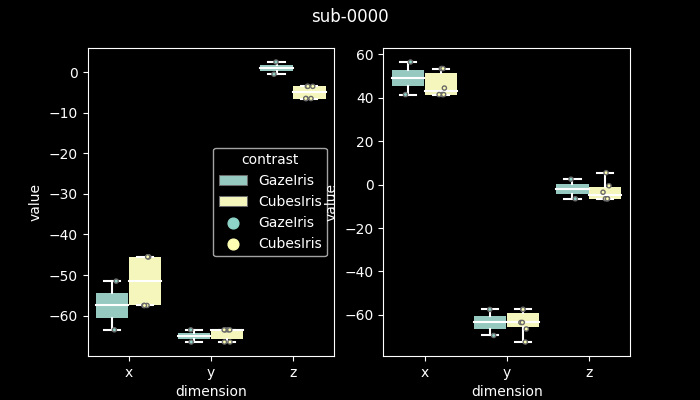

In [24]:
sub_id = 'sub-0000'

fig, axs = plt.subplots(1,2,figsize=(7,4))

PROPS = {
    'boxprops':{'edgecolor':'None'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'white'},
    'capprops':{'color':'white'}
}

g = sns.boxplot(
    x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='left') & 
        (peaks_df.reference=='Marquardt2017') &
        (
            ((peaks_df.contrast=='GazeIris') & (peaks_df.sign==1)) |  
            ((peaks_df.contrast=='CubesIris') & (peaks_df.sign==1))
        )], 
    hue_order=['GazeIris', 'CubesIris'],
    ax=axs[0],
    **PROPS)

g.legend_.texts[0].set_text('Gaze > Iris')
g.legend_.texts[1].set_text('Cubes > Iris')

sns.stripplot(x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='left') & 
        (peaks_df.reference=='Marquardt2017') &
        (
            ((peaks_df.contrast=='GazeIris') & (peaks_df.sign==1)) |  
            ((peaks_df.contrast=='CubesIris') & (peaks_df.sign==1))
        )], 
    hue_order=['GazeIris', 'CubesIris'],
    ax=axs[0],
    dodge=True,
    linewidth=1,
    edgecolor='gray',
    size=3)


g = sns.boxplot(
    x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='right') & 
        (peaks_df.reference=='Marquardt2017') &
        (
            ((peaks_df.contrast=='GazeIris') & (peaks_df.sign==1)) |  
            ((peaks_df.contrast=='CubesIris') & (peaks_df.sign==1))
        )], 
    hue_order=['GazeIris', 'CubesIris'],
    ax=axs[1],
    **PROPS)

sns.stripplot(x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='right') & 
        (peaks_df.reference=='Marquardt2017') &
        (
            ((peaks_df.contrast=='GazeIris') & (peaks_df.sign==1)) |  
            ((peaks_df.contrast=='CubesIris') & (peaks_df.sign==1))
        )], 
    hue_order=['GazeIris', 'CubesIris'],
    ax=axs[1],
    dodge=True,
    linewidth=1,
    edgecolor='gray',
    size=3)
plt.legend([],[], frameon=False)



plt.suptitle(sub_id)

# plt.legend(title='Smoker', loc='upper left', labels=['Hell Yeh', 'Nah Bruh'])


Text(0.5, 0.98, 'sub-0000')

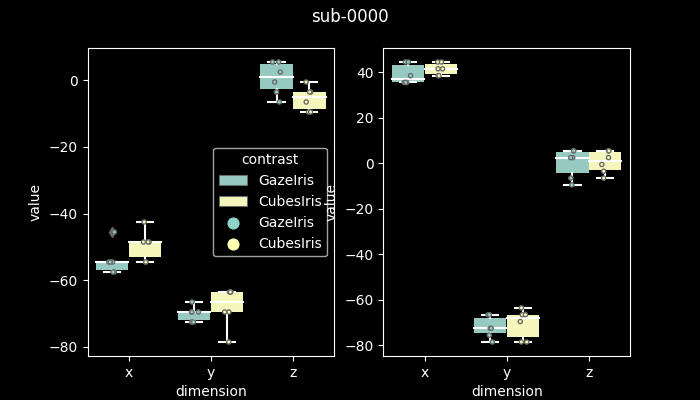

In [84]:
sub_id = 'sub-0000'

fig, axs = plt.subplots(1,2,figsize=(7,4))

PROPS = {
    'boxprops':{'edgecolor':'None'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'white'},
    'capprops':{'color':'white'}
}

g = sns.boxplot(
    x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='left') & 
        (peaks_df.reference=='visual_motion') &
        (
            ((peaks_df.contrast=='GazeIris') & (peaks_df.sign=='positive')) |  
            ((peaks_df.contrast=='CubesIris') & (peaks_df.sign=='positive'))
        )], 
    hue_order=['GazeIris', 'CubesIris'],
    ax=axs[0],
    **PROPS)

g.legend_.texts[0].set_text('Gaze > Iris')
g.legend_.texts[1].set_text('Cubes > Iris')

sns.stripplot(x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='left') & 
        (peaks_df.reference=='visual_motion') &
        (
            ((peaks_df.contrast=='GazeIris') & (peaks_df.sign=='positive')) |  
            ((peaks_df.contrast=='CubesIris') & (peaks_df.sign=='positive'))
        )], 
    hue_order=['GazeIris', 'CubesIris'],
    ax=axs[0],
    dodge=True,
    linewidth=1,
    edgecolor='gray',
    size=3)


g = sns.boxplot(
    x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='right') & 
        (peaks_df.reference=='visual_motion') &
        (
            ((peaks_df.contrast=='GazeIris') & (peaks_df.sign=='positive')) |  
            ((peaks_df.contrast=='CubesIris') & (peaks_df.sign=='positive'))
        )], 
    hue_order=['GazeIris', 'CubesIris'],
    ax=axs[1],
    **PROPS)

sns.stripplot(x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='right') & 
        (peaks_df.reference=='visual_motion') &
        (
            ((peaks_df.contrast=='GazeIris') & (peaks_df.sign=='positive')) |  
            ((peaks_df.contrast=='CubesIris') & (peaks_df.sign=='positive'))
        )], 
    hue_order=['GazeIris', 'CubesIris'],
    ax=axs[1],
    dodge=True,
    linewidth=1,
    edgecolor='gray',
    size=3)
plt.legend([],[], frameon=False)



plt.suptitle(sub_id)

# plt.legend(title='Smoker', loc='upper left', labels=['Hell Yeh', 'Nah Bruh'])


#### CubesIris vs CubesGaze

Text(0.5, 0.98, 'sub-00')

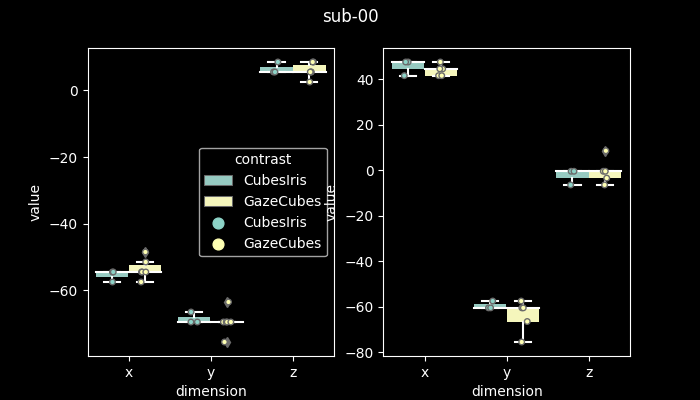

In [29]:
sub_id = 'sub-00'

fig, axs = plt.subplots(1,2,figsize=(7,4))

PROPS = {
    'boxprops':{'edgecolor':'None'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'white'},
    'capprops':{'color':'white'}
}

g = sns.boxplot(
    x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='left') & 
        (peaks_df.reference=='Marquardt2017') &
        (
            ((peaks_df.contrast=='CubesIris') & (peaks_df.sign==1)) |  
            ((peaks_df.contrast=='GazeCubes') & (peaks_df.sign==-1))
        )], 
    hue_order=['CubesIris', 'GazeCubes'],
    ax=axs[0],
    **PROPS)

g.legend_.texts[0].set_text('Cubes > Iris')
g.legend_.texts[1].set_text('Cubes > Gaze')

sns.stripplot(x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='left') & 
        (peaks_df.reference=='Marquardt2017') &
        (
            ((peaks_df.contrast=='CubesIris') & (peaks_df.sign==1)) |  
            ((peaks_df.contrast=='GazeCubes') & (peaks_df.sign==-1))
        )], 
    hue_order=['CubesIris', 'GazeCubes'],
    ax=axs[0],
    dodge=True,
    linewidth=1,
    edgecolor='gray',
    size=4)
plt.legend([],[], frameon=False)



g = sns.boxplot(
    x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='right') & 
        (peaks_df.reference=='Marquardt2017') &
        (
            ((peaks_df.contrast=='CubesIris') & (peaks_df.sign==1)) |  
            ((peaks_df.contrast=='GazeCubes') & (peaks_df.sign==-1))
        )], 
    hue_order=['CubesIris', 'GazeCubes'],
    ax=axs[1],
    **PROPS)
plt.legend([],[], frameon=False)


sns.stripplot(x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='right') & 
        (peaks_df.reference=='Marquardt2017') &
        (
            ((peaks_df.contrast=='CubesIris') & (peaks_df.sign==1)) |  
            ((peaks_df.contrast=='GazeCubes') & (peaks_df.sign==-1))
        )], 
    hue_order=['CubesIris', 'GazeCubes'],
    ax=axs[1],
    dodge=True,
    linewidth=1,
    edgecolor='gray',
    size=4)
plt.legend([],[], frameon=False)



plt.suptitle(sub_id)

# plt.legend(title='Smoker', loc='upper left', labels=['Hell Yeh', 'Nah Bruh'])


Text(0.5, 0.98, 'sub-00')

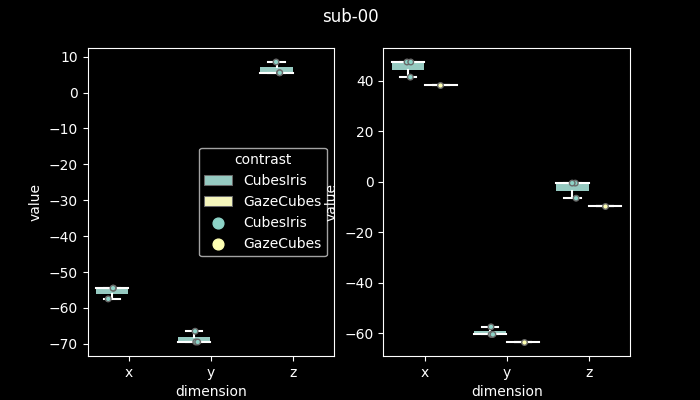

In [28]:
sub_id = 'sub-00'

fig, axs = plt.subplots(1,2,figsize=(7,4))

PROPS = {
    'boxprops':{'edgecolor':'None'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'white'},
    'capprops':{'color':'white'}
}

g = sns.boxplot(
    x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='left') & 
        (peaks_df.reference=='Marquardt2017') &
        (
            ((peaks_df.contrast=='CubesIris') & (peaks_df.sign==1)) |  
            ((peaks_df.contrast=='GazeCubes') & (peaks_df.sign==1))
        )], 
    hue_order=['CubesIris', 'GazeCubes'],
    ax=axs[0],
    **PROPS)

g.legend_.texts[0].set_text('Cubes > Iris')
g.legend_.texts[1].set_text('Gaze > Cubes')

sns.stripplot(x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='left') & 
        (peaks_df.reference=='Marquardt2017') &
        (
            ((peaks_df.contrast=='CubesIris') & (peaks_df.sign==1)) |  
            ((peaks_df.contrast=='GazeCubes') & (peaks_df.sign==1))
        )], 
    hue_order=['CubesIris', 'GazeCubes'],
    ax=axs[0],
    dodge=True,
    linewidth=1,
    edgecolor='gray',
    size=4)


g = sns.boxplot(
    x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='right') & 
        (peaks_df.reference=='Marquardt2017') &
        (
            ((peaks_df.contrast=='CubesIris') & (peaks_df.sign==1)) |  
            ((peaks_df.contrast=='GazeCubes') & (peaks_df.sign==1))
        )], 
    hue_order=['CubesIris', 'GazeCubes'],
    ax=axs[1],
    **PROPS)

sns.stripplot(x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='right') & 
        (peaks_df.reference=='Marquardt2017') &
        (
            ((peaks_df.contrast=='CubesIris') & (peaks_df.sign==1)) |  
            ((peaks_df.contrast=='GazeCubes') & (peaks_df.sign==1))
        )], 
    hue_order=['CubesIris', 'GazeCubes'],
    ax=axs[1],
    dodge=True,
    linewidth=1,
    edgecolor='gray',
    size=4)
plt.legend([],[], frameon=False)



plt.suptitle(sub_id)

# plt.legend(title='Smoker', loc='upper left', labels=['Hell Yeh', 'Nah Bruh'])


In [10]:
plt.close('all')

Text(0.5, 0.98, 'sub-0000')

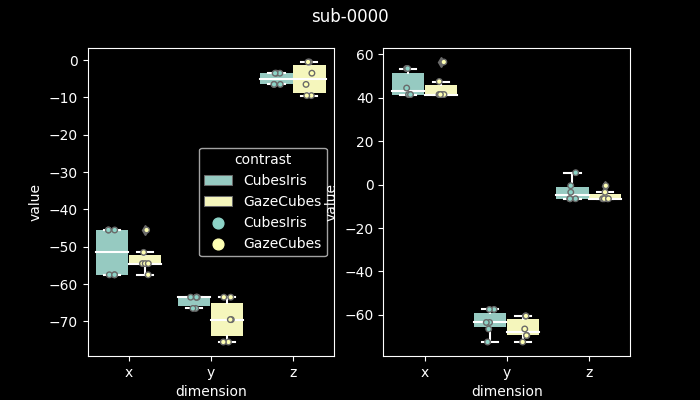

In [30]:
sub_id = 'sub-0000'

fig, axs = plt.subplots(1,2,figsize=(7,4))

PROPS = {
    'boxprops':{'edgecolor':'None'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'white'},
    'capprops':{'color':'white'}
}

g = sns.boxplot(
    x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='left') & 
        (peaks_df.reference=='Marquardt2017') &
        (
            ((peaks_df.contrast=='CubesIris') & (peaks_df.sign==1)) |  
            ((peaks_df.contrast=='GazeCubes') & (peaks_df.sign==-1))
        )], 
    hue_order=['CubesIris', 'GazeCubes'],
    ax=axs[0],
    **PROPS)

g.legend_.texts[0].set_text('Cubes > Iris')
g.legend_.texts[1].set_text('Cubes > Gaze')

sns.stripplot(x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='left') & 
        (peaks_df.reference=='Marquardt2017') &
        (
            ((peaks_df.contrast=='CubesIris') & (peaks_df.sign==1)) |  
            ((peaks_df.contrast=='GazeCubes') & (peaks_df.sign==-1))
        )], 
    hue_order=['CubesIris', 'GazeCubes'],
    ax=axs[0],
    dodge=True,
    linewidth=1,
    edgecolor='gray',
    size=4)
plt.legend([],[], frameon=False)



g = sns.boxplot(
    x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='right') & 
        (peaks_df.reference=='Marquardt2017') &
        (
            ((peaks_df.contrast=='CubesIris') & (peaks_df.sign==1)) |  
            ((peaks_df.contrast=='GazeCubes') & (peaks_df.sign==-1))
        )], 
    hue_order=['CubesIris', 'GazeCubes'],
    ax=axs[1],
    **PROPS)
plt.legend([],[], frameon=False)


sns.stripplot(x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='right') & 
        (peaks_df.reference=='Marquardt2017') &
        (
            ((peaks_df.contrast=='CubesIris') & (peaks_df.sign==1)) |  
            ((peaks_df.contrast=='GazeCubes') & (peaks_df.sign==-1))
        )], 
    hue_order=['CubesIris', 'GazeCubes'],
    ax=axs[1],
    dodge=True,
    linewidth=1,
    edgecolor='gray',
    size=4)
plt.legend([],[], frameon=False)



plt.suptitle(sub_id)

# plt.legend(title='Smoker', loc='upper left', labels=['Hell Yeh', 'Nah Bruh'])


Text(0.5, 0.98, 'sub-0000')

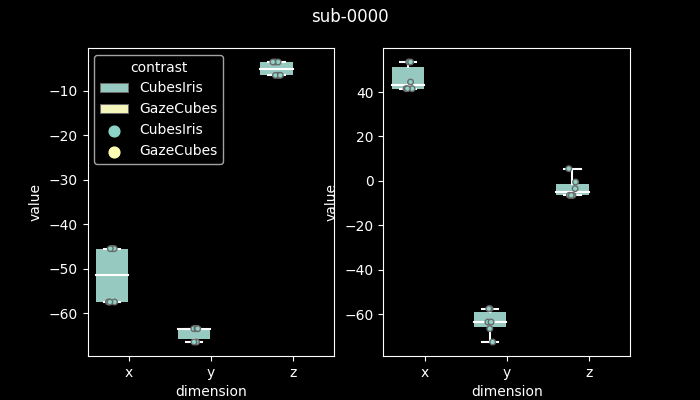

In [32]:
sub_id = 'sub-0000'

fig, axs = plt.subplots(1,2,figsize=(7,4))

PROPS = {
    'boxprops':{'edgecolor':'None'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'white'},
    'capprops':{'color':'white'}
}

g = sns.boxplot(
    x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='left') & 
        (peaks_df.reference=='Marquardt2017') &
        (
            ((peaks_df.contrast=='CubesIris') & (peaks_df.sign==1)) |  
            ((peaks_df.contrast=='GazeCubes') & (peaks_df.sign==1))
        )], 
    hue_order=['CubesIris', 'GazeCubes'],
    ax=axs[0],
    **PROPS)

g.legend_.texts[0].set_text('Cubes > Iris')
g.legend_.texts[1].set_text('Gaze > Cubes')

sns.stripplot(x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='left') & 
        (peaks_df.reference=='Marquardt2017') &
        (
            ((peaks_df.contrast=='CubesIris') & (peaks_df.sign==1)) |  
            ((peaks_df.contrast=='GazeCubes') & (peaks_df.sign==1))
        )], 
    hue_order=['CubesIris', 'GazeCubes'],
    ax=axs[0],
    dodge=True,
    linewidth=1,
    edgecolor='gray',
    size=4)


g = sns.boxplot(
    x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='right') & 
        (peaks_df.reference=='Marquardt2017') &
        (
            ((peaks_df.contrast=='CubesIris') & (peaks_df.sign==1)) |  
            ((peaks_df.contrast=='GazeCubes') & (peaks_df.sign==1))
        )], 
    hue_order=['CubesIris', 'GazeCubes'],
    ax=axs[1],
    **PROPS)

sns.stripplot(x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='right') & 
        (peaks_df.reference=='Marquardt2017') &
        (
            ((peaks_df.contrast=='CubesIris') & (peaks_df.sign==1)) |  
            ((peaks_df.contrast=='GazeCubes') & (peaks_df.sign==1))
        )], 
    hue_order=['CubesIris', 'GazeCubes'],
    ax=axs[1],
    dodge=True,
    linewidth=1,
    edgecolor='gray',
    size=4)
plt.legend([],[], frameon=False)



plt.suptitle(sub_id)

# plt.legend(title='Smoker', loc='upper left', labels=['Hell Yeh', 'Nah Bruh'])


#### GazeIris vs Motion Static

Text(0.5, 0.98, 'sub-0000')

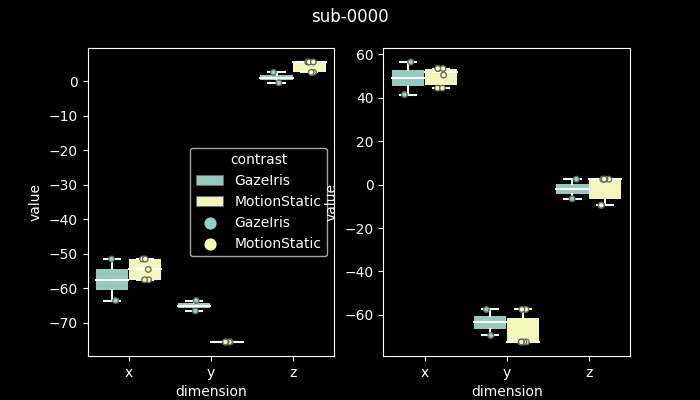

In [33]:
sub_id = 'sub-0000'

fig, axs = plt.subplots(1,2,figsize=(7,4))

PROPS = {
    'boxprops':{'edgecolor':'None'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'white'},
    'capprops':{'color':'white'}
}

g = sns.boxplot(
    x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='left') & 
        (peaks_df.reference=='Marquardt2017') &
        (
            ((peaks_df.contrast=='GazeIris') & (peaks_df.sign==1)) |  
            ((peaks_df.contrast=='MotionStatic') & (peaks_df.sign==1))
        )], 
    hue_order=['GazeIris', 'MotionStatic'],
    ax=axs[0],
    **PROPS)

g.legend_.texts[0].set_text('Gaze > Iris')
g.legend_.texts[1].set_text('Motion > Static')

sns.stripplot(x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='left') & 
        (peaks_df.reference=='Marquardt2017') &
        (
            ((peaks_df.contrast=='GazeIris') & (peaks_df.sign==1)) |  
            ((peaks_df.contrast=='MotionStatic') & (peaks_df.sign==1))
        )], 
    hue_order=['GazeIris', 'MotionStatic'],
    ax=axs[0],
    dodge=True,
    linewidth=1,
    edgecolor='gray',
    size=4)


g = sns.boxplot(
    x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='right') & 
        (peaks_df.reference=='Marquardt2017') &
        (
            ((peaks_df.contrast=='GazeIris') & (peaks_df.sign==1)) |  
            ((peaks_df.contrast=='MotionStatic') & (peaks_df.sign==1))
        )], 
    hue_order=['GazeIris', 'MotionStatic'],
    ax=axs[1],
    **PROPS)

sns.stripplot(x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='right') & 
        (peaks_df.reference=='Marquardt2017') &
        (
            ((peaks_df.contrast=='GazeIris') & (peaks_df.sign==1)) |  
            ((peaks_df.contrast=='MotionStatic') & (peaks_df.sign==1))
        )], 
    hue_order=['GazeIris', 'MotionStatic'],
    ax=axs[1],
    dodge=True,
    linewidth=1,
    edgecolor='gray',
    size=4)
plt.legend([],[], frameon=False)



plt.suptitle(sub_id)

# plt.legend(title='Smoker', loc='upper left', labels=['Hell Yeh', 'Nah Bruh'])


#### CubesIris vs Motion Static

Text(0.5, 0.98, 'sub-00')

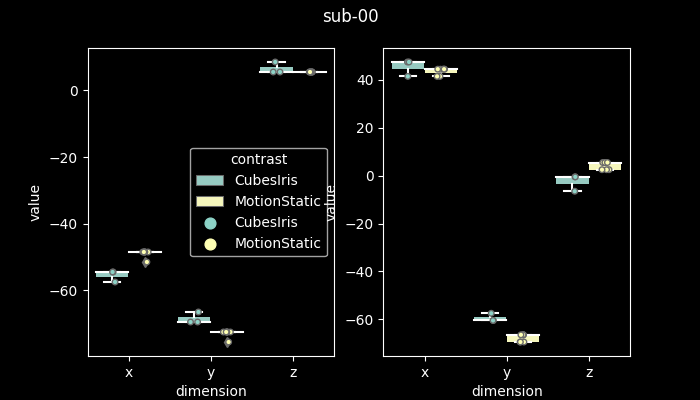

In [34]:
sub_id = 'sub-00'

fig, axs = plt.subplots(1,2,figsize=(7,4))

PROPS = {
    'boxprops':{'edgecolor':'None'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'white'},
    'capprops':{'color':'white'}
}

g = sns.boxplot(
    x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='left') & 
        (peaks_df.reference=='Marquardt2017') &
        (
            ((peaks_df.contrast=='CubesIris') & (peaks_df.sign==1)) |  
            ((peaks_df.contrast=='MotionStatic') & (peaks_df.sign==1))
        )], 
    hue_order=['CubesIris', 'MotionStatic'],
    ax=axs[0],
    **PROPS)

g.legend_.texts[0].set_text('Cubes > Iris')
g.legend_.texts[1].set_text('Motion > Static')

sns.stripplot(x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='left') & 
        (peaks_df.reference=='Marquardt2017') &
        (
            ((peaks_df.contrast=='CubesIris') & (peaks_df.sign==1)) |  
            ((peaks_df.contrast=='MotionStatic') & (peaks_df.sign==1))
        )], 
    hue_order=['CubesIris', 'MotionStatic'],
    ax=axs[0],
    dodge=True,
    linewidth=1,
    edgecolor='gray',
    size=4)


g = sns.boxplot(
    x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='right') & 
        (peaks_df.reference=='Marquardt2017') &
        (
            ((peaks_df.contrast=='CubesIris') & (peaks_df.sign==1)) |  
            ((peaks_df.contrast=='MotionStatic') & (peaks_df.sign==1))
        )], 
    hue_order=['CubesIris', 'MotionStatic'],
    ax=axs[1],
    **PROPS)

sns.stripplot(x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='right') & 
        (peaks_df.reference=='Marquardt2017') &
        (
            ((peaks_df.contrast=='CubesIris') & (peaks_df.sign==1)) |  
            ((peaks_df.contrast=='MotionStatic') & (peaks_df.sign==1))
        )], 
    hue_order=['CubesIris', 'MotionStatic'],
    ax=axs[1],
    dodge=True,
    linewidth=1,
    edgecolor='gray',
    size=4)
plt.legend([],[], frameon=False)



plt.suptitle(sub_id)

# plt.legend(title='Smoker', loc='upper left', labels=['Hell Yeh', 'Nah Bruh'])


Text(0.5, 0.98, 'sub-0000')

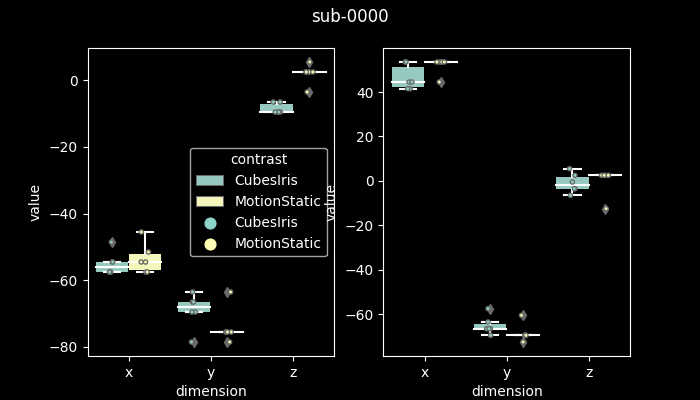

In [89]:
sub_id = 'sub-0000'

fig, axs = plt.subplots(1,2,figsize=(7,4))

PROPS = {
    'boxprops':{'edgecolor':'None'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'white'},
    'capprops':{'color':'white'}
}

g = sns.boxplot(
    x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='left') & 
        (peaks_df.reference=='Marquardt2017') &
        (
            ((peaks_df.contrast=='CubesIris') & (peaks_df.sign=='positive')) |  
            ((peaks_df.contrast=='MotionStatic') & (peaks_df.sign=='positive'))
        )], 
    hue_order=['CubesIris', 'MotionStatic'],
    ax=axs[0],
    **PROPS)

g.legend_.texts[0].set_text('Cubes > Iris')
g.legend_.texts[1].set_text('Motion > Static')

sns.stripplot(x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='left') & 
        (peaks_df.reference=='Marquardt2017') &
        (
            ((peaks_df.contrast=='CubesIris') & (peaks_df.sign=='positive')) |  
            ((peaks_df.contrast=='MotionStatic') & (peaks_df.sign=='positive'))
        )], 
    hue_order=['CubesIris', 'MotionStatic'],
    ax=axs[0],
    dodge=True,
    linewidth=1,
    edgecolor='gray',
    size=3)


g = sns.boxplot(
    x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='right') & 
        (peaks_df.reference=='Marquardt2017') &
        (
            ((peaks_df.contrast=='CubesIris') & (peaks_df.sign=='positive')) |  
            ((peaks_df.contrast=='MotionStatic') & (peaks_df.sign=='positive'))
        )], 
    hue_order=['CubesIris', 'MotionStatic'],
    ax=axs[1],
    **PROPS)

sns.stripplot(x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ 
        (peaks_df.participant==sub_id) & 
        (peaks_df.hemisphere=='right') & 
        (peaks_df.reference=='Marquardt2017') &
        (
            ((peaks_df.contrast=='CubesIris') & (peaks_df.sign=='positive')) |  
            ((peaks_df.contrast=='MotionStatic') & (peaks_df.sign=='positive'))
        )], 
    hue_order=['CubesIris', 'MotionStatic'],
    ax=axs[1],
    dodge=True,
    linewidth=1,
    edgecolor='gray',
    size=3)
plt.legend([],[], frameon=False)



plt.suptitle(sub_id)

# plt.legend(title='Smoker', loc='upper left', labels=['Hell Yeh', 'Nah Bruh'])


<AxesSubplot:xlabel='dimension', ylabel='value'>

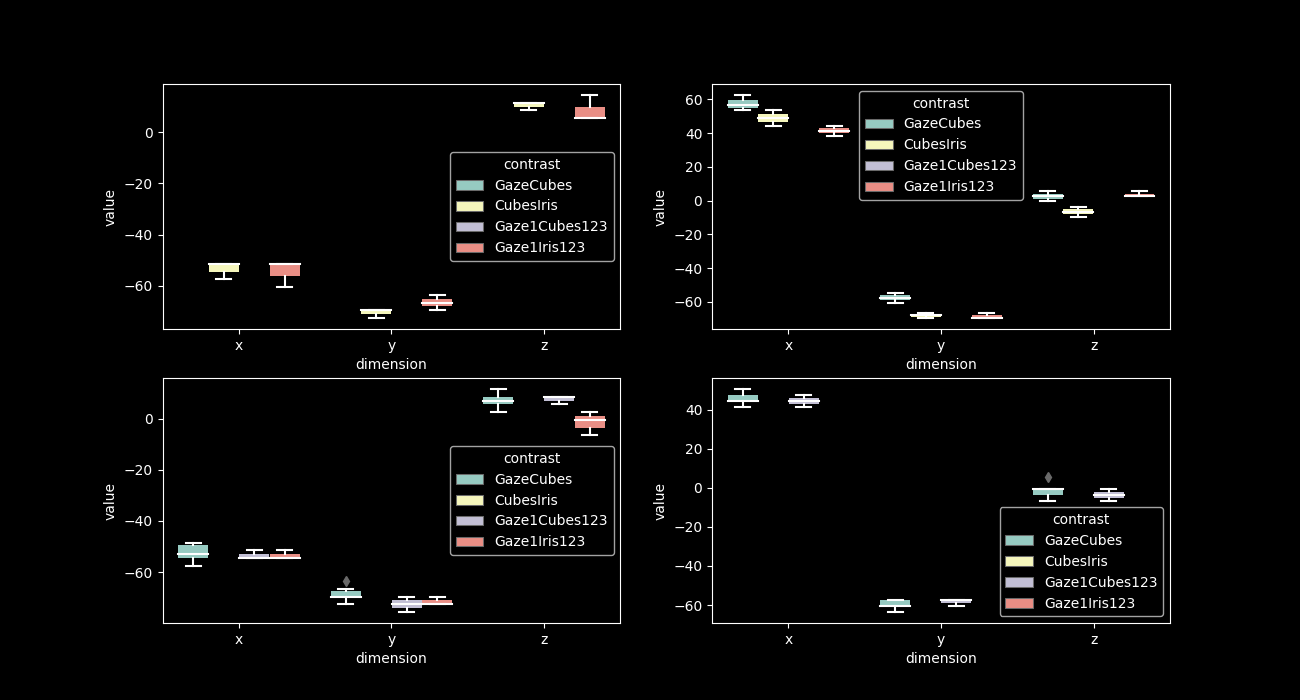

In [626]:
fig, axs = plt.subplots(2,2,figsize=(13,7))

PROPS = {
    'boxprops':{'edgecolor':'None'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'white'},
    'capprops':{'color':'white'}
}

sns.boxplot(
    x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ (peaks_df.participant=='sub-00') & (peaks_df.hemisphere=='left') & (peaks_df.sign=='positive') ], 
    hue_order=['GazeCubes', 'CubesIris', 'Gaze1Cubes123', 'Gaze1Iris123'],
    ax=axs[0,0],
    **PROPS)

sns.boxplot(
    x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ (peaks_df.participant=='sub-00') & (peaks_df.hemisphere=='right') & (peaks_df.sign=='positive')  ], 
    hue_order=['GazeCubes', 'CubesIris', 'Gaze1Cubes123', 'Gaze1Iris123'],
    ax=axs[0,1],
    **PROPS)

sns.boxplot(
    x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ (peaks_df.participant=='sub-00') & (peaks_df.hemisphere=='left') & (peaks_df.sign=='negative') ], 
    hue_order=['GazeCubes', 'CubesIris', 'Gaze1Cubes123', 'Gaze1Iris123'],
    ax=axs[1,0],
    **PROPS)

sns.boxplot(
    x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ (peaks_df.participant=='sub-00') & (peaks_df.hemisphere=='right') & (peaks_df.sign=='negative')  ], 
    hue_order=['GazeCubes', 'CubesIris', 'Gaze1Cubes123', 'Gaze1Iris123'],
    ax=axs[1,1],
    **PROPS)

<AxesSubplot:xlabel='dimension', ylabel='value'>

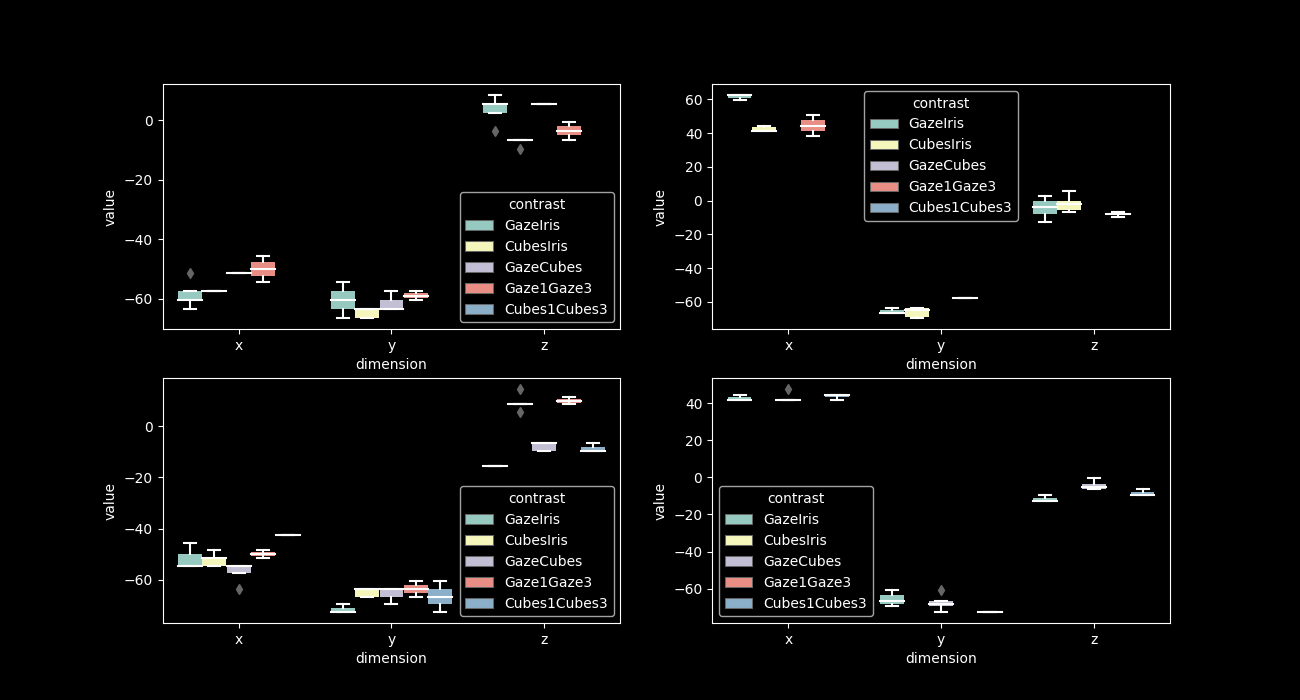

In [624]:
fig, axs = plt.subplots(2,2,figsize=(13,7))

PROPS = {
    'boxprops':{'edgecolor':'None'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'white'},
    'capprops':{'color':'white'}
}

ax_ = sns.boxplot(
    x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ (peaks_df.participant=='sub-0000') & (peaks_df.hemisphere=='left') & (peaks_df.sign=='positive') ], 
    hue_order=['GazeIris', 'CubesIris', 'GazeCubes', 'Gaze1Gaze3', 'Cubes1Cubes3'],
    ax=axs[0,0],
    **PROPS)



sns.boxplot(
    x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ (peaks_df.participant=='sub-0000') & (peaks_df.hemisphere=='right') & (peaks_df.sign=='positive') ], 
    hue_order=['GazeIris', 'CubesIris', 'GazeCubes', 'Gaze1Gaze3', 'Cubes1Cubes3'],
    ax=axs[0,1],
    **PROPS)

sns.boxplot(
    x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ (peaks_df.participant=='sub-0000') & (peaks_df.hemisphere=='left') & (peaks_df.sign=='negative') ], 
    hue_order=['GazeIris', 'CubesIris', 'GazeCubes', 'Gaze1Gaze3', 'Cubes1Cubes3'],
    ax=axs[1,0],
    **PROPS)

sns.boxplot(
    x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ (peaks_df.participant=='sub-0000') & (peaks_df.hemisphere=='right') & (peaks_df.sign=='negative') ], 
    hue_order=['GazeIris', 'CubesIris', 'GazeCubes', 'Gaze1Gaze3', 'Cubes1Cubes3'],
    ax=axs[1,1],
    **PROPS)



In [ ]:
fig, axs = plt.subplots(2,2,figsize=(13,7))
sns.boxplot(
    x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ (peaks_df.participant=='sub-0000') & (peaks_df.hemisphere=='left') & (peaks_df.sign=='positive') ], 
    hue_order=['GazeCubes', 'CubesIris', 'Gaze1Cubes123', 'Gaze1Iris123'],
    ax=axs[0,0])

sns.boxplot(
    x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ (peaks_df.participant=='sub-0000') & (peaks_df.hemisphere=='right') & (peaks_df.sign=='positive')  ], 
    hue_order=['GazeCubes', 'CubesIris', 'Gaze1Cubes123', 'Gaze1Iris123'],
    ax=axs[0,1])

sns.boxplot(
    x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ (peaks_df.participant=='sub-0000') & (peaks_df.hemisphere=='left') & (peaks_df.sign=='negative') ], 
    hue_order=['GazeCubes', 'CubesIris', 'Gaze1Cubes123', 'Gaze1Iris123'],
    ax=axs[1,0])

sns.boxplot(
    x='dimension', 
    y='value', 
    hue='contrast', 
    data=peaks_df[ (peaks_df.participant=='sub-0000') & (peaks_df.hemisphere=='right') & (peaks_df.sign=='negative')  ], 
    hue_order=['GazeCubes', 'CubesIris', 'Gaze1Cubes123', 'Gaze1Iris123'],
    ax=axs[1,1])

#### Interactive plot


Gaze1Iris123
------------------
Loaded image:  ['/home/marius/ownCloud/PhD/projects/scientific/gaze-motion/results/from_nilearn/univariate_contrasts/sub-00/gic/sub-00_task-gic_run-1_Gaze1Iris123_fwhm-5_duration-0_hrfModel-gdd_z-score.nii.gz']


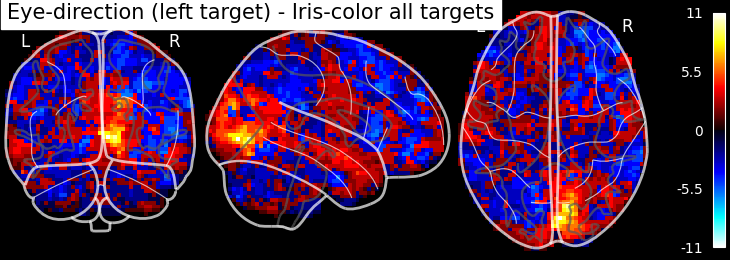


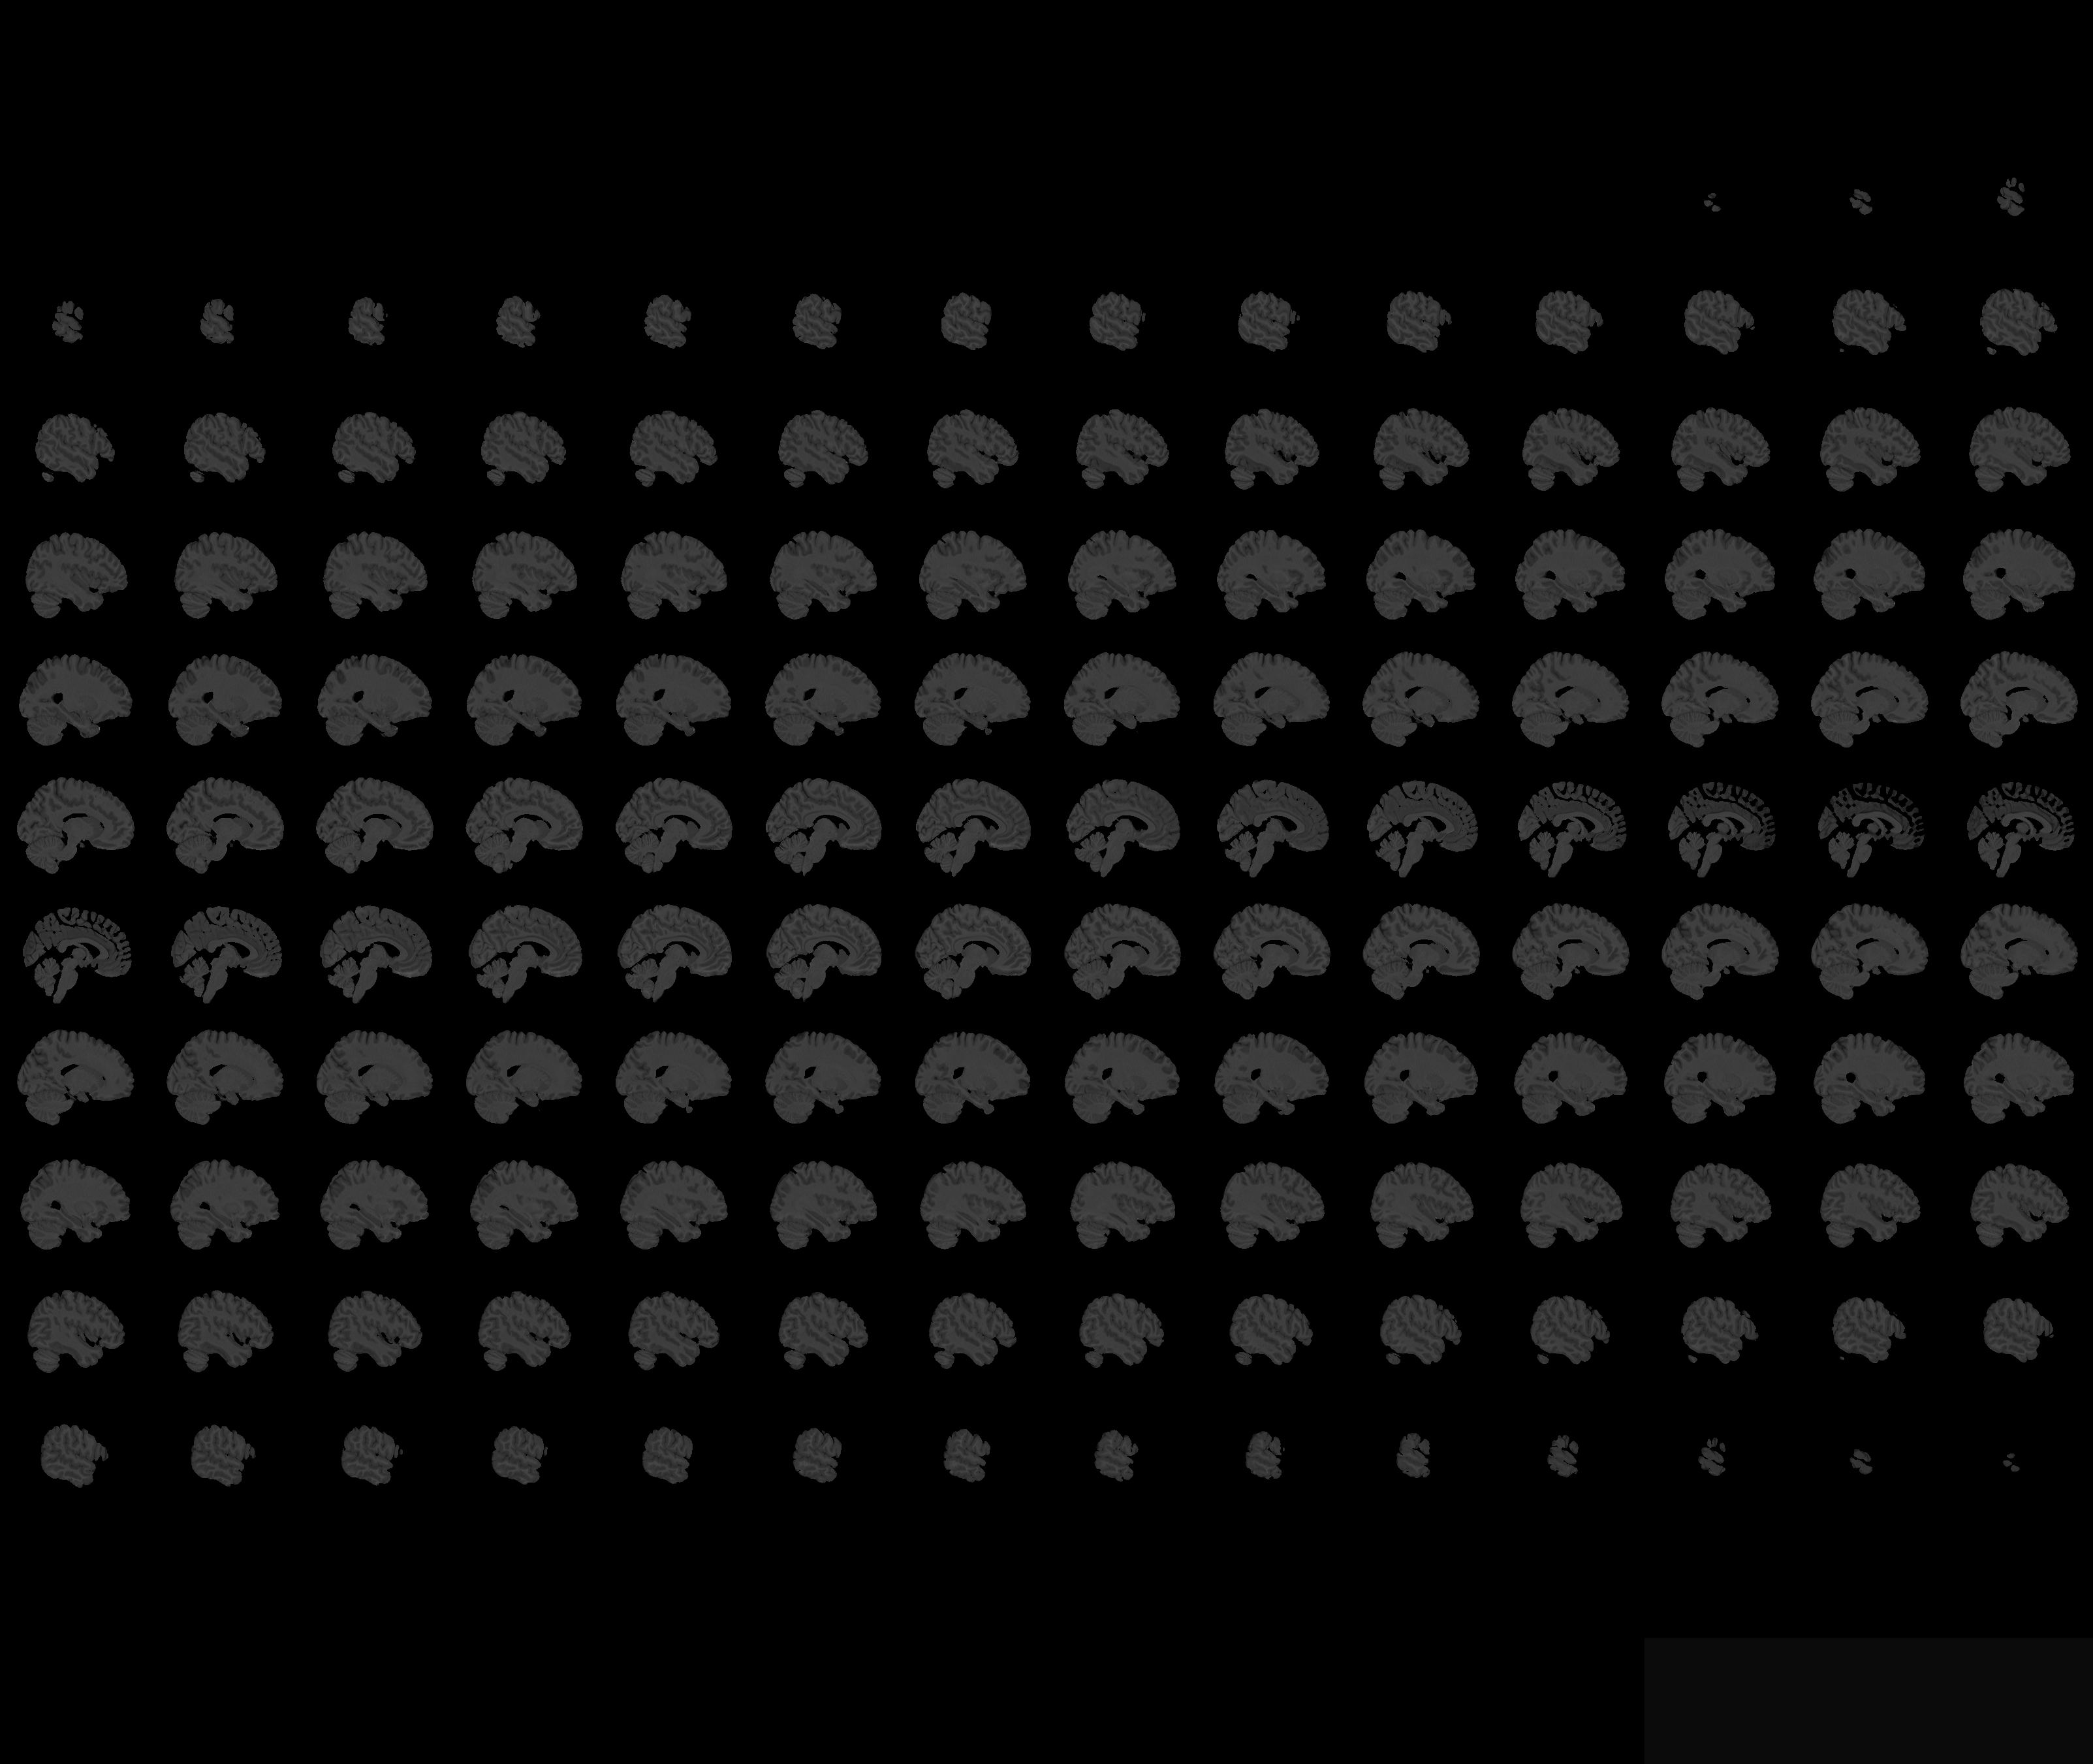
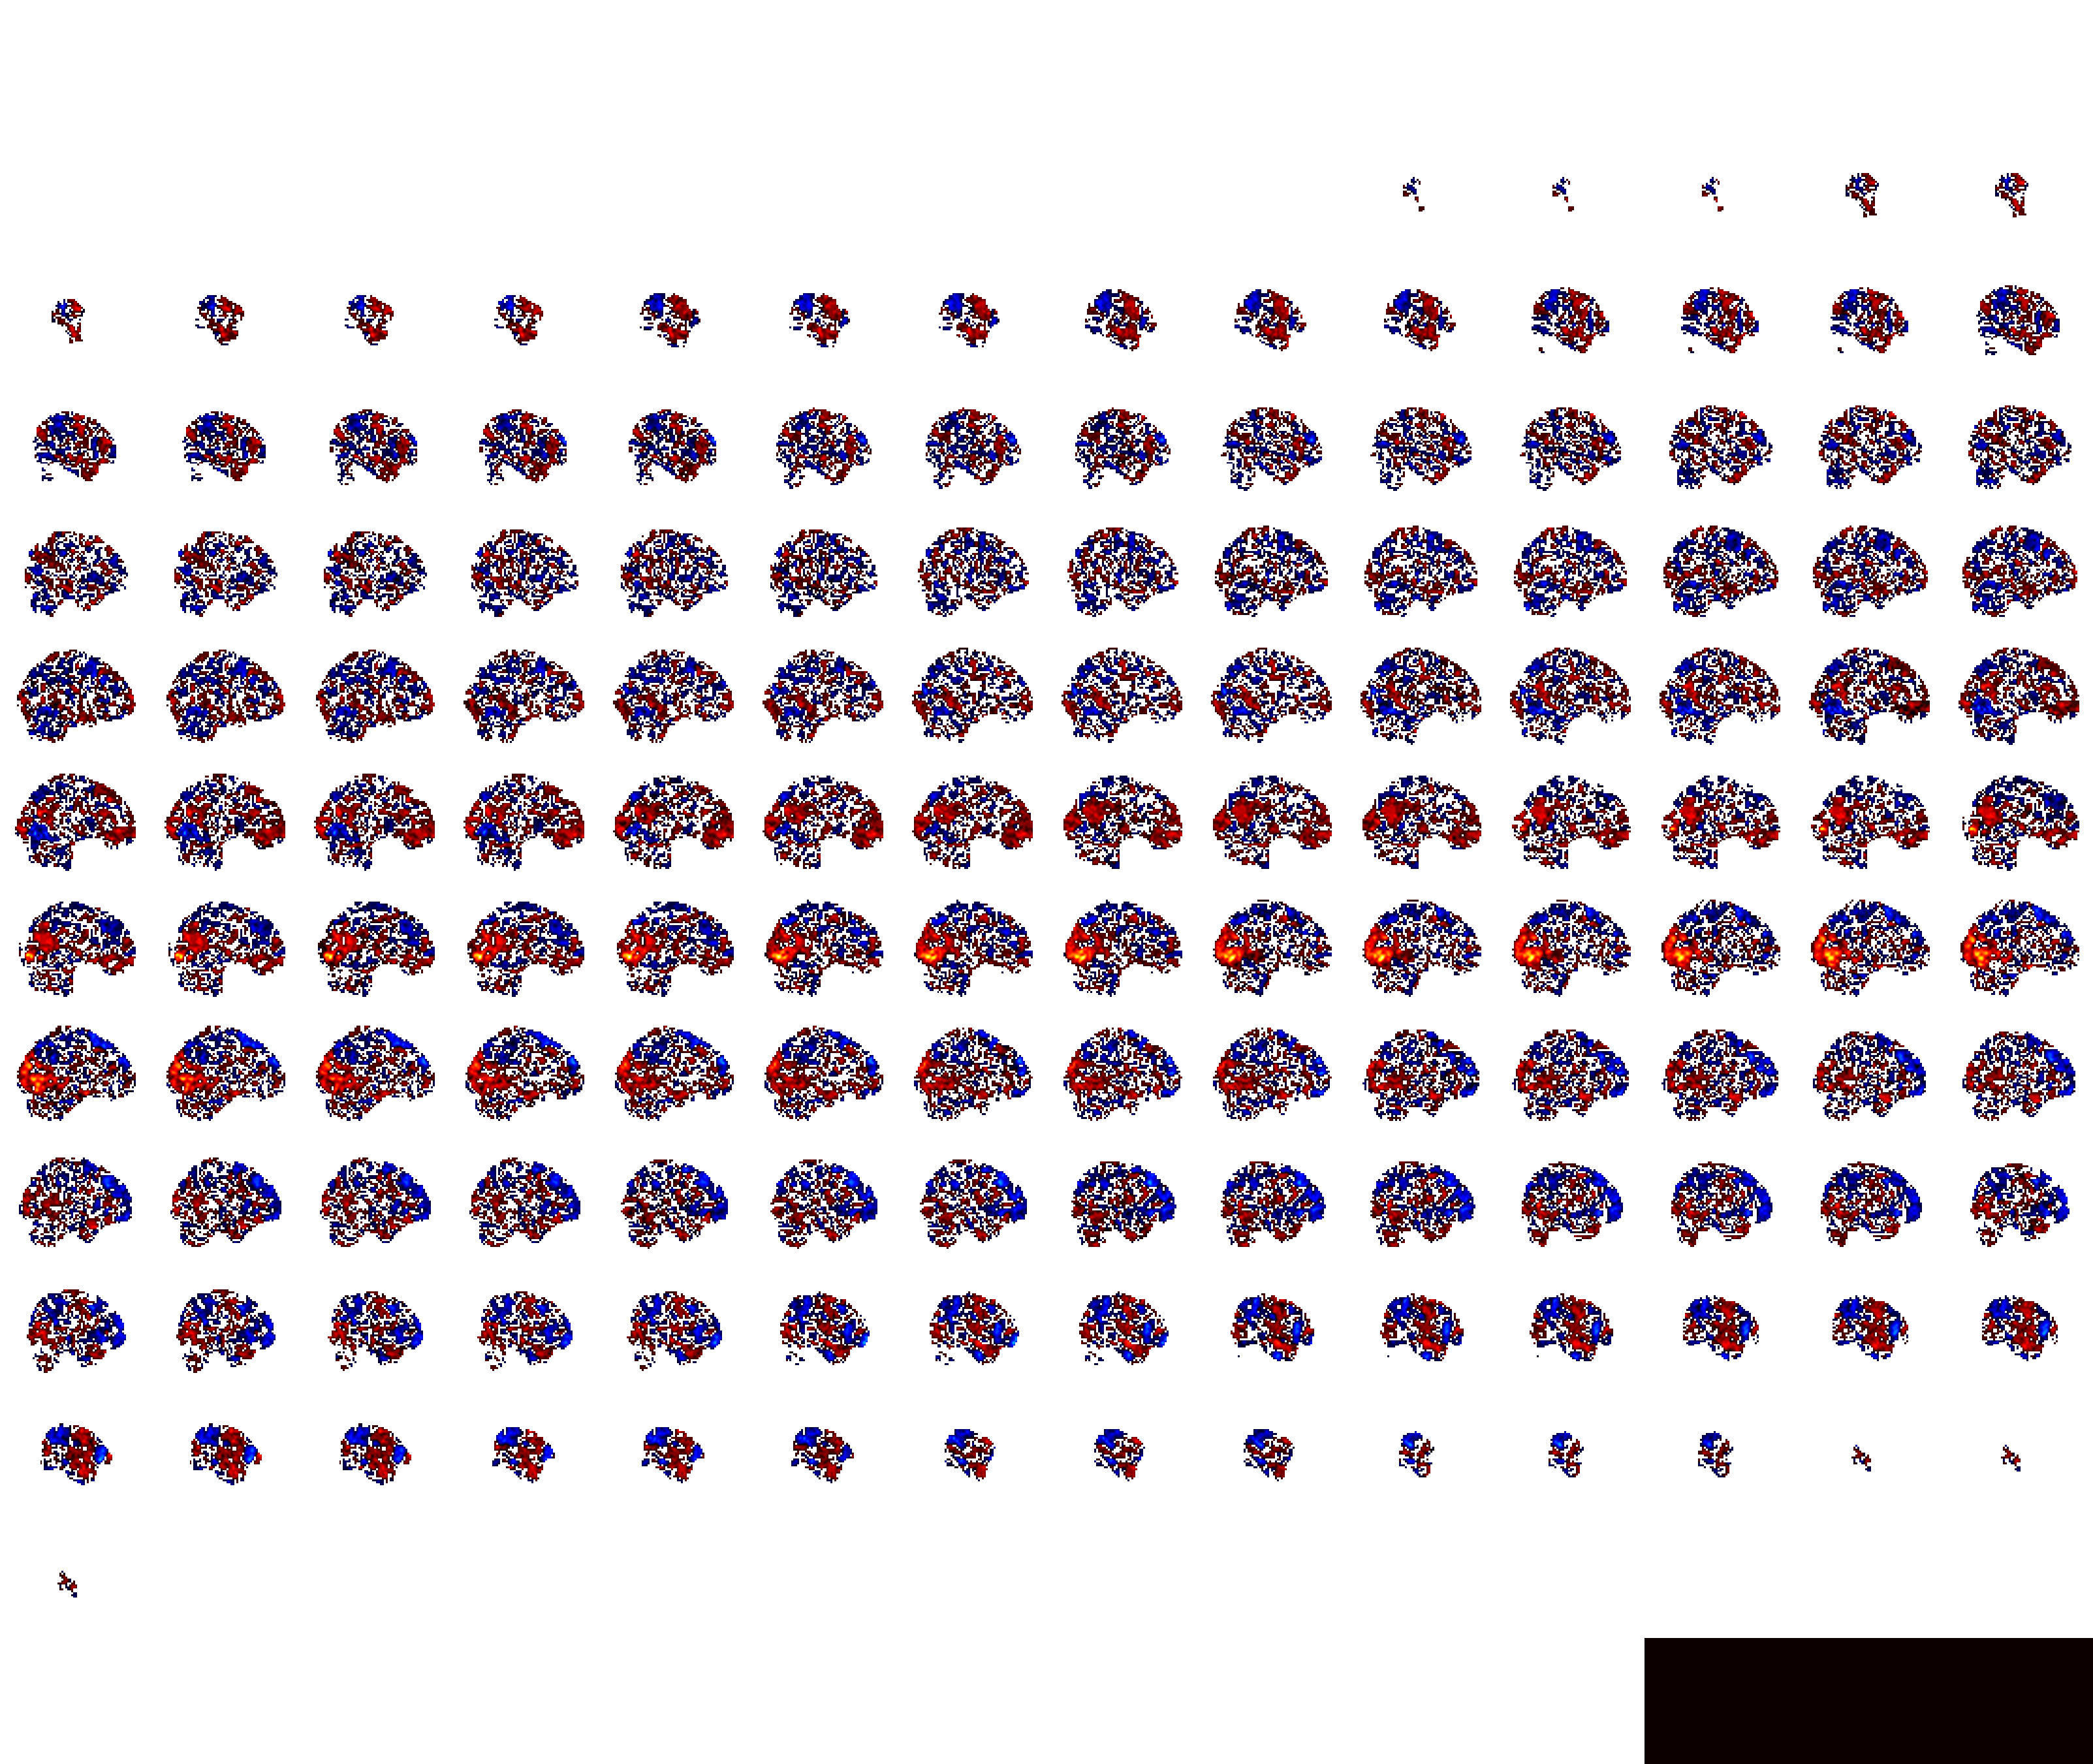

In [19]:
plt.close('all')
figure_dict = Bunch( 
    
    gic = Bunch(
        Gaze1Iris123   = Bunch(
            run_set='run-1', 
            which_map='z-score', 
            fwhm='fwhm-5', 
            specs='hrfModel-gdd', 
            alpha=1, 
            h_control='fpr', 
            c_threshold=3, 
            vmax=None, 
            colorbar=False, 
            cut_coords=(41.5, -66.5, 5.5), 
            glass=True
        )
    )
)


clust_frame = subjects['sub-00']['ses-com'].interactive_plot(figure_dict)


In [ ]:
Gaze1Iris123
					 [(-54.5, -72.5, -6.5), (41.5, -66.5, 5.5)] [-3.0, 5.0] [-1.0, 1.0]
					 [(-57.5, -75.5, -0.5), (44.5, -69.5, 2.5)] [-3.0, 6.0] [-1.0, 1.0]
					 [(-42.5, -63.5, 2.5), (38.5, -78.5, -6.5)] [4.0, -4.0] [1.0, -1.0]

In [91]:
peaks_df[
    (peaks_df.participant == 'sub-0000') & 
    ((peaks_df.contrast == 'GazeIris') | (peaks_df.contrast == 'GazeIris')) & 
    (peaks_df.sign == 'positive') &
    (peaks_df.run == 'run-1') 
    # (peaks_df.hemisphere == 'left')
].head(40)

participant task  contrast      sign    run hemisphere dimension  value  \
528    sub-0000  gic  GazeIris  positive  run-1       left         x  -54.5   
529    sub-0000  gic  GazeIris  positive  run-1       left         y  -66.5   
530    sub-0000  gic  GazeIris  positive  run-1       left         z    5.5   
531    sub-0000  gic  GazeIris  positive  run-1      right         x   44.5   
532    sub-0000  gic  GazeIris  positive  run-1      right         y  -78.5   
533    sub-0000  gic  GazeIris  positive  run-1      right         z   -6.5   
744    sub-0000  gic  GazeIris  positive  run-1       left         x  -54.5   
745    sub-0000  gic  GazeIris  positive  run-1       left         y  -66.5   
746    sub-0000  gic  GazeIris  positive  run-1       left         z    5.5   
747    sub-0000  gic  GazeIris  positive  run-1      right         x   44.5   
748    sub-0000  gic  GazeIris  positive  run-1      right         y  -57.5   
749    sub-0000  gic  GazeIris  positive  run-1      right         z   -9.5   

     dist_to_ref      reference  
528     9.836158  visual_motion  
529     9.836158  visual_motion  
530     9.836158  visual_motion  
531    13.518506  visual_motion  
532    13.518506  visual_motion  
533    13.518506  visual_motion  
744     8.529361  Marquardt2017  
745     8.529361  Marquardt2017  
746     8.529361  Marquardt2017  
747    10.712143  Marquardt2017  
748    10.712143  Marquardt2017  
749    10.712143  Marquardt2017

In [706]:
np.linalg.norm(np.array([-46, -70, 2]-np.array([-33.5, -66.5, 2.5])))

12.99038105676658

In [459]:
# ## TESTING

# nii_img = image.load_img([el for el in subjects['sub-00']['ses-gc'].univariate.results['MTLoc']['run-1']['MotionStatic']['fwhm-'+str(fwhm)] if img_type in el][0])
# nii_img, _ = threshold_stats_img(nii_img, alpha=0.01, height_control='fpr', cluster_threshold=3)

# img_arr = nii_img.get_fdata()
# img_arr_p = img_arr.copy()
# img_arr_n = img_arr.copy()
# img_arr_p[img_arr_p<0] = 0
# img_arr_n[img_arr_n>0] = 0
# img_arr_n = np.abs(img_arr_n)

# nii_img_p = image.new_img_like(nii_img, img_arr_p)
# nii_img_n = image.new_img_like(nii_img, img_arr_n)

# img = nii_img_p.get_fdata()

# coords = peak_local_max(img, min_distance=3)

# dists = []
# coords_mni=[]

# for crd in coords:
#     crd = np.c_[
#         np.atleast_1d(crd[0]).flat,
#         np.atleast_1d(crd[1]).flat,
#         np.atleast_1d(crd[2]).flat,
#         np.ones_like(np.atleast_1d(crd[0]).flat)].T
#     x, y, z, _ = np.dot(nii_img.affine, crd)
#     x = np.round(x[0], decimals=2)
#     y = np.round(y[0], decimals=2)
#     z = np.round(z[0], decimals=2)
    
#     dist_ = np.linalg.norm(np.array([x,y,z])-np.array([-57.5, -63.5, -6.5]))
#     dists.append(dist_)
#     coords_mni.append([x,y,z])
#     # print([x,y,z], dist_)
    
# coords_mni[np.argsort(dists)[0]]

[-42.5, -60.5, -0.5]

## ROI overlap

### testing

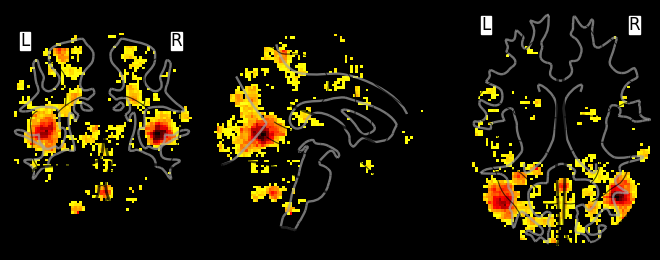

In [6]:
img_f = "/home/marius/ownCloud/PhD/projects/scientific/gaze-motion/analysis/gm_analysis/src/ROIs/neurosynth/originals/visual motion_association-test_z_FDR_0.01.nii.gz"
plotting.plot_glass_brain(img_f)

In [7]:
img_ = image.load_img(img_f)

In [8]:
img_arr = img_.get_fdata()

In [16]:
np.argmax(img_arr, keepdims=True)

array([[[230813]]])

In [13]:
np.shape(img_arr)

(91, 109, 91)

In [11]:
img_arr[230813]

IndexError: index 230813 is out of bounds for axis 0 with size 91

In [17]:
plotting.find_xyz_cut_coords(img_)

[44.341081286267766, -66.86424787704486, 2.011855095257772]

In [19]:
import sys
sys.path.append( sys.path.append('/home/marius/ownCloud/development/python/atlasreader/atlasreader') )
import atlasreader

In [21]:
df = atlasreader.create_output(
                    img_, cluster_extent=0, atlas=['juelich', 'harvard_oxford'])

In [24]:
df[0]

peak_x  peak_y  peak_z  cluster_mean  volume_mm  \
cluster_id                                                    
1            -42.0   -74.0     4.0      6.068291    11584.0   
2             44.0   -68.0     2.0      6.634919     8864.0   
3              4.0   -60.0   -42.0      5.422667     1384.0   
4             24.0   -76.0    28.0      4.809250     1312.0   
5            -32.0   -52.0    66.0      5.516540     1000.0   
...            ...     ...     ...           ...        ...   
283          -50.0    -2.0    20.0      4.398441        8.0   
284           -2.0  -104.0     4.0      3.916781        8.0   
285            0.0   -70.0   -40.0      4.228915        8.0   
286            0.0   -72.0   -42.0      4.834838        8.0   
287          -44.0   -68.0   -12.0      3.768534        8.0   

                                                      juelich  \
cluster_id                                                      
1           43.02% GM_Visual_cortex_V5_L; 21.06% no_label;...   
2           49.82% GM_Visual_cortex_V5_R; 16.16% no_label;...   
3                                            100.00% no_label   
4                 89.02% no_label; 7.32% WM_Optic_radiation_R   
5           67.20% GM_Superior_parietal_lobule_7A_L; 32.00...   
...                                                       ...   
283            100.00% GM_Primary_somatosensory_cortex_BA3a_L   
284                        100.00% GM_Visual_cortex_V1_BA17_L   
285                                          100.00% no_label   
286                                          100.00% no_label   
287                                          100.00% no_label   

                                               harvard_oxford  
cluster_id                                                     
1           70.58% Left_Lateral_Occipital_Cortex_inferior_...  
2           77.71% Right_Lateral_Occipital_Cortex_inferior...  
3                                            100.00% no_label  
4           91.46% Right_Lateral_Occipital_Cortex_superior...  
5                        95.20% Left_Superior_Parietal_Lobule  
...                                                       ...  
283                             100.00% Left_Precentral_Gyrus  
284                               100.00% Left_Occipital_Pole  
285                                          100.00% no_label  
286                                          100.00% no_label  
287         100.00% Left_Lateral_Occipital_Cortex_inferior...  

[287 rows x 7 columns]

In [ ]:
sub_id = 'sub-0000'
ses_id = 'ses-com'

## get mask for reference
_, _, left_ref_mask, right_ref_mask, _, _, _ = subjects[sub_id][ses_id].compute_masks(
    # img_=subjects[sub_id][ses_id].univariate.results[task_id]['run-1-2-3-4-5-6']['GazeCubes']['fwhm-5'][-1],
    task='gic',
    runs='run-1-2-3-4-5-6',
    con='GazeCubes',
    sign='both',
    alpha=0.00001,
    h_control='bonferroni',
    cluster_threshold=3,
    fwhm=5,
    ref_img='MTloc',
    use_lbls=False,
    plot_components=True,
    store=False)

plotting.plot_glass_brain(
                    image.math_img('a+b', a=left_ref_mask, b=right_ref_mask), title='Reference ROIs')



left_arr, right_arr, left_mask, right_mask, img_name, left_distance_to_ref, right_distance_to_ref = subjects[sub_id][ses_id].compute_masks(
    task='gic',
    runs='run-1-2-3-4-5-6',
    con='Gaze1Gaze3',
    sign='both',
    alpha=0.05,
    h_control="fdr",
    cluster_threshold=3,
    fwhm=5,
    ref_img=[left_ref_mask, right_ref_mask],
    use_lbls=False,
    plot_components=False,
    store=False
)

plotting.plot_glass_brain(
    image.math_img('a+b', a=left_mask, b=right_mask))

### Collect masks

In [5]:
subjects['sub-0000']['ses-com'].info.ROIs.functional['GazeCubes'][0]

'/home/marius/ownCloud/PhD/projects/scientific/gaze-motion/analysis/gm_analysis/src/ROIs/individual/sub-0000/functional/sub-0000_task-gic_GazeCubes-both_fwhm-None_p0.01-fdr_ROI-mask_GazeCubes-left.nii'


*** sub-00

Gaze1Iris123
*** Using /home/marius/ownCloud/PhD/projects/scientific/gaze-motion/analysis/gm_analysis/src/ROIs/individual/sub-00/functional/sub-00_task-gic_Gaze1Iris123-positive_fwhm-5_p0.01-fpr_ROI-mask_gGFP-left.nii /home/marius/ownCloud/PhD/projects/scientific/gaze-motion/analysis/gm_analysis/src/ROIs/individual/sub-00/functional/sub-00_task-gic_Gaze1Iris123-positive_fwhm-5_p0.01-fpr_ROI-mask_gGFP-right.nii as reference.
run-1, ['/home/marius/ownCloud/PhD/projects/scientific/gaze-motion/results/from_nilearn/univariate_contrasts/sub-00/gic/sub-00_task-gic_run-1_Gaze1Iris123_fwhm-5_duration-0_hrfModel-gdd_z-score.nii.gz']
*** Coordinates used for reference:  [15.7 22.7 28.4] [47.82716049 22.04938272 28.39506173]
['/home/marius/ownCloud/PhD/projects/scientific/gaze-motion/results/from_nilearn/univariate_contrasts/sub-00/gic/sub-00_task-gic_run-1_Gaze1Iris123_fwhm-5_duration-0_hrfModel-gdd_z-score.nii.gz']
*** Coordinates used for reference:  [15.7 22.7 28.4] [47.82716049 2

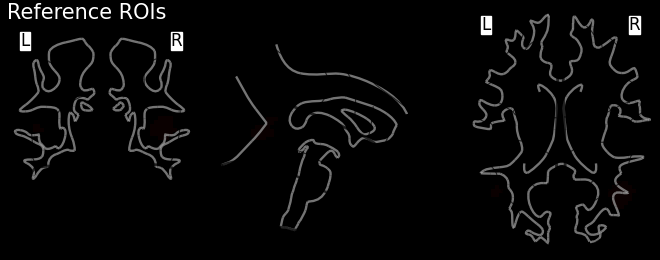

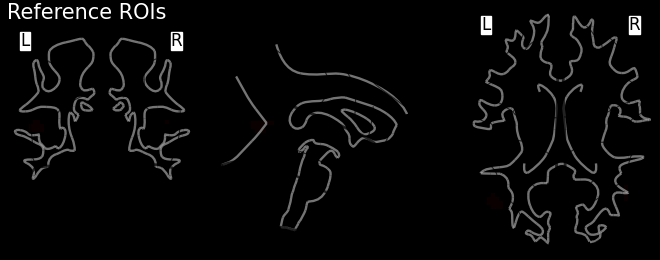

In [136]:

fwhm = 5
threshold_values_ = [[0.01, "bonferroni"], 
                     [0.05, "bonferroni"], 
                     [0.01, "fdr"], 
                     [0.02, "fdr"], 
                     [0.03, "fdr"], 
                     [0.04, "fdr"], 
                     [0.05, "fdr"], 
                     [0.01, "fpr"],
                     [0.02, "fpr"], 
                     [0.03, "fpr"], 
                     [0.04, "fpr"], 
                     [0.05, "fpr"]]

sets = {
    'sub-00': {
        # 'ses-gc':{
        #     'gc': {
        #         'GazeCubes': {
        #             'reference': {
        #                 'alpha': 0.01, # used if img is specified
        #                 'h_control': 'fdr', # used if img is specified
        #                 'img': False, #[el for el in subjects['sub-00']['ses-gc'].univariate.results.gc['run-1-2-3-4-5-6']['Gaze1Gaze3']['fwhm-5'] if 'z-score' in el][0], # image or False
        #                 'left_ref_mask': subjects['sub-00']['ses-gc'].info.ROIs.functional['GazeCubes'][0], # mask image or False
        #                 'right_ref_mask': subjects['sub-00']['ses-gc'].info.ROIs.functional['GazeCubes'][1] # mask image or False
        #             },
        #             'runs': ['run-1', 'run-2', 'run-3'],#, 'run-4', 'run-5', 'run-6'],
        #             'runs_thrshs': { # if specified it must contain as many entries as number of runs of the form [[alpha, height],...], use Flase if no threshold should be specified
        #                 'left': [False, False, False, False, False, False],
        #                 'right': [False, False, False, False, False, False]},
        #             'con_specs': ''
        #         }
        #     },
        #     'MTloc': {
        #         'MotionStatic': {
        #             'reference': {
        #                 'alpha': 0.01, # used imf img is specified
        #                 'h_control': 'fdr', # used imf img is specified
        #                 'img': False, #[el for el in subjects['sub-00']['ses-gc'].univariate.results.gc['run-1-2-3-4-5-6']['Gaze1Gaze3']['fwhm-5'] if 'z-score' in el][0], # image or False
        #                 'left_ref_mask': subjects['sub-00']['ses-gc'].info.ROIs.functional['fMotionArea'][0], # mask image or False
        #                 'right_ref_mask': subjects['sub-00']['ses-gc'].info.ROIs.functional['fMotionArea'][1] # mask image or False
        #             },
        #             'runs': ['run-1', 'run-2', 'run-3', 'run-4', 'run-5', 'run-6', 'run-7'],
        #             'runs_thrshs': { # if specified it must contain as many entries as number of runs of the form [[alpha, height],...], use Flase if no threshold should be specified
        #                 'left': [[0.01, 'fpr'], False, False, False, False, False, False],
        #                 'right': [[0.01, 'fpr'], False, False, False, False, False, False]},
        #             'con_specs': ''
        #         }
        #     }
        # },
        'ses-com':{
            'gic': {
                # 'GazeCubes': {
                #     'reference': {
                #         'alpha': 0.01, # used imf img is specified
                #         'h_control': 'fdr', # used imf img is specified
                #         'img': False, #[el for el in subjects['sub-00']['ses-gc'].univariate.results.gc['run-1-2-3-4-5-6']['Gaze1Gaze3']['fwhm-5'] if 'z-score' in el][0], # image or False
                #         'left_ref_mask': subjects['sub-00']['ses-gc'].info.ROIs.functional['GazeCubes'][0], # mask image or False
                #         'right_ref_mask': subjects['sub-00']['ses-gc'].info.ROIs.functional['GazeCubes'][1] # mask image or False
                #     },
                #     'runs': ['run-1', 'run-2', 'run-3'],
                #     'runs_thrshs': { # if specified it must contain as many entries as number of runs of the form [[alpha, height],...], use Flase if no threshold should be specified
                #         'left': [False, False, False],
                #         'right': [False, False, False]},
                #     'con_specs': ''
                # },
                # 'CubesIris': {
                #     'reference': {
                #         'alpha': 0.01, # used imf img is specified
                #         'h_control': 'fdr', # used imf img is specified
                #         'img': False, #[el for el in subjects['sub-00']['ses-gc'].univariate.results.gc['run-1-2-3-4-5-6']['Gaze1Gaze3']['fwhm-5'] if 'z-score' in el][0], # image or False
                #         'left_ref_mask': subjects['sub-00']['ses-com'].info.ROIs.functional['cGFP'][0], # mask image or False
                #         'right_ref_mask': subjects['sub-00']['ses-com'].info.ROIs.functional['cGFP'][1] # mask image or False
                #     },
                #     'runs': ['run-1', 'run-2', 'run-3'],
                #     'runs_thrshs': { # if specified it must contain as many entries as number of runs of the form [[alpha, height],...], use Flase if no threshold should be specified
                #         'left': [False, False, False],
                #         'right': [False, False, False]},
                #     'con_specs': ''
                # },
                'Gaze1Iris123': {
                    'reference': {
                        'alpha': 0.01, # used imf img is specified
                        'h_control': 'fdr', # used imf img is specified
                        'img': False, #[el for el in subjects['sub-00']['ses-gc'].univariate.results.gc['run-1-2-3-4-5-6']['Gaze1Gaze3']['fwhm-5'] if 'z-score' in el][0], # image or False
                        'left_ref_mask': subjects['sub-00']['ses-com'].info.ROIs.functional['gGFP'][0], # mask image or False
                        'right_ref_mask': subjects['sub-00']['ses-com'].info.ROIs.functional['gGFP'][1] # mask image or False
                    },
                    'runs': ['run-1', 'run-2', 'run-3'],
                    'runs_thrshs': { # if specified it must contain as many entries as number of runs of the form [[alpha, height],...], use Flase if no threshold should be specified
                        'left': [False, False, False],
                        'right': [False, False, False]},
                    'con_specs': ''
                }
            }
        }
    },
    ###
    'sub-0000': {
        'ses-com':{
            'gic': {
                # 'GazeCubes': {
                #     'reference': {
                #         'alpha': 0.01, # used imf img is specified
                #         'h_control': 'fdr', # used imf img is specified
                #         'img': False, #[el for el in subjects['sub-00']['ses-gc'].univariate.results.gc['run-1-2-3-4-5-6']['Gaze1Gaze3']['fwhm-5'] if 'z-score' in el][0], # image or False
                #         'left_ref_mask': subjects['sub-0000']['ses-com'].info.ROIs.functional['GazeCubes'][0], # mask image or False
                #         'right_ref_mask': subjects['sub-0000']['ses-com'].info.ROIs.functional['GazeCubes'][1] # mask image or False
                #     },
                #     'runs': ['run-1', 'run-2', 'run-3', 'run-4', 'run-5', 'run-6'],
                #     'runs_thrshs': { # if specified it must contain as many entries as number of runs of the form [[alpha, height],...], use Flase if no threshold should be specified
                #         'left': [False, False, False, False, False, False],
                #         'right': [False, False, False, False, False, False]},
                #     'con_specs': 'cue-aligned_duration-0_hrfModel-gdd'
                # },
                # 'CubesIris': {
                #     'reference': {
                #         'alpha': 0.01, # used imf img is specified
                #         'h_control': 'fdr', # used imf img is specified
                #         'img': False, #[el for el in subjects['sub-00']['ses-gc'].univariate.results.gc['run-1-2-3-4-5-6']['Gaze1Gaze3']['fwhm-5'] if 'z-score' in el][0], # image or False
                #         'left_ref_mask': subjects['sub-0000']['ses-com'].info.ROIs.functional['cGFP'][0], # mask image or False
                #         'right_ref_mask': subjects['sub-0000']['ses-com'].info.ROIs.functional['cGFP'][1] # mask image or False
                #     },
                #     'runs': ['run-1', 'run-2', 'run-3', 'run-4', 'run-5', 'run-6'],
                #     'runs_thrshs': { # if specified it must contain as many entries as number of runs of the form [[alpha, height],...], use Flase if no threshold should be specified
                #         'left': [False, False, False, False, [0.01, 'fdr'], False],
                #         'right': [False, False, False, False, [0.05, 'fdr'], False]},
                #     'con_specs': 'cue-aligned_duration-0_hrfModel-gdd'
                # },
                'GazeIris': {
                    'reference': {
                        'alpha': 0.01, # used imf img is specified
                        'h_control': 'fdr', # used imf img is specified
                        'img': False, #[el for el in subjects['sub-00']['ses-gc'].univariate.results.gc['run-1-2-3-4-5-6']['Gaze1Gaze3']['fwhm-5'] if 'z-score' in el][0], # image or False
                        'left_ref_mask': subjects['sub-0000']['ses-com'].info.ROIs.functional['gGFP'][0], # mask image or False
                        'right_ref_mask': subjects['sub-0000']['ses-com'].info.ROIs.functional['gGFP'][1] # mask image or False
                    },
                    'runs': ['run-1', 'run-2', 'run-3', 'run-4', 'run-5', 'run-6'],
                    'runs_thrshs': { # if specified it must contain as many entries as number of runs of the form [[alpha, height],...], use Flase if no threshold should be specified
                        'left': [False, False, False, False, False, False],
                        'right': [False, False, False, False, False, False]},
                    'con_specs': 'cue-aligned_duration-0_hrfModel-gdd'
                }
            },
            # 'MTloc': {
            #     'MotionStatic': {
            #         'reference': {
            #             'alpha': 0.01, # used imf img is specified
            #             'h_control': 'fdr', # used imf img is specified
            #             'img': False, #[el for el in subjects['sub-00']['ses-gc'].univariate.results.gc['run-1-2-3-4-5-6']['Gaze1Gaze3']['fwhm-5'] if 'z-score' in el][0], # image or False
            #             'left_ref_mask': subjects['sub-0000']['ses-com'].info.ROIs.functional['fMotionArea'][0], # mask image or False
            #             'right_ref_mask': subjects['sub-0000']['ses-com'].info.ROIs.functional['fMotionArea'][1] # mask image or False
            #         },
            #         'runs': ['run-1', 'run-2', 'run-3', 'run-4', 'run-5', 'run-6'],
            #         'runs_thrshs': { # if specified it must contain as many entries as number of runs of the form [[alpha, height],...], use Flase if no threshold should be specified
            #             'left': [False, False, False, False, False, False],
            #             'right': [False, False, False, False, False, False]},
            #         'con_specs': 'hrfModel-gdd'
            #     }
            # }
        }
    }
}

mask_collector = {}
for sub_id in sets:
    print('')
    print('***', sub_id)
    
    mask_collector[sub_id] = {}
    
    for ses_id in sets[sub_id]:
        
        subs_mask_collector = subjects[sub_id][ses_id].collect_masks(
            sets[sub_id][ses_id],
            fwhm,
            threshold_values_,
            use_lbls=False,
            plot_components=False)

        for task_id in subs_mask_collector:
            mask_collector[sub_id][task_id] = subs_mask_collector[task_id]

#### Check collected masks

In [16]:
plt.close('all')

*************
sub-00
  gic
   Gaze1Iris123
     run-1
     [0.05, 'fpr']
     [0.01, 'fpr']


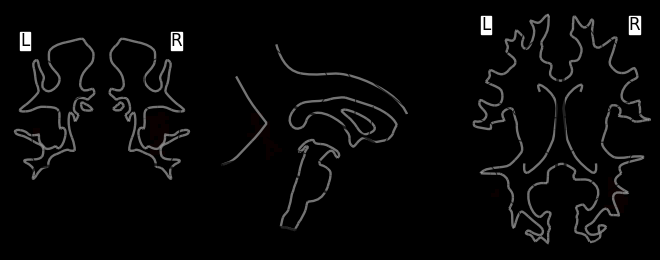

     run-2
     [0.05, 'fpr']
     [0.05, 'fpr']


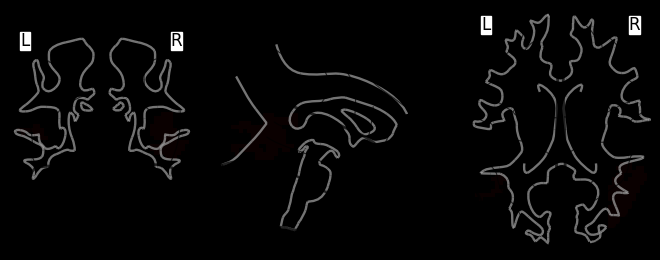

     run-3
     [0.01, 'fpr']
     [0.01, 'fpr']


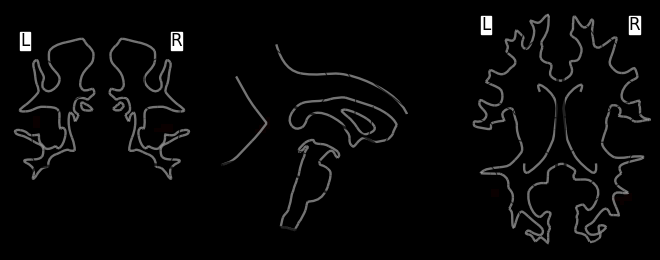

*************
sub-0000
  gic
   GazeIris
     run-1
     [0.05, 'fpr']
     [0.05, 'fpr']


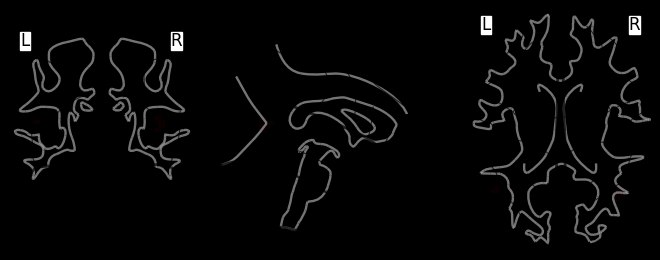

     run-2
     [0.01, 'fpr']
     [0.01, 'bonferroni']


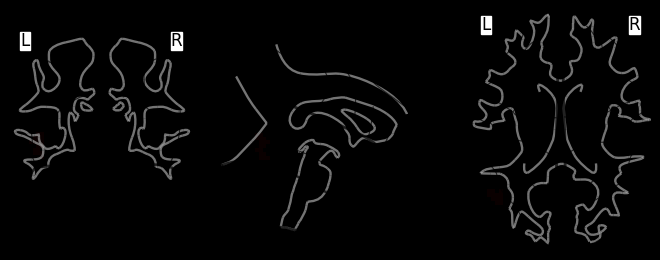

     run-3
     [0.01, 'bonferroni']
     [0.05, 'fpr']


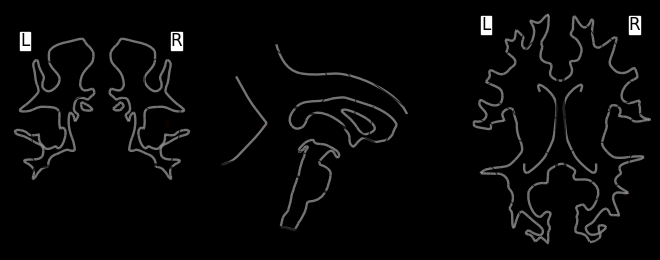

     run-4
     [0.05, 'fpr']
     [0.01, 'fpr']


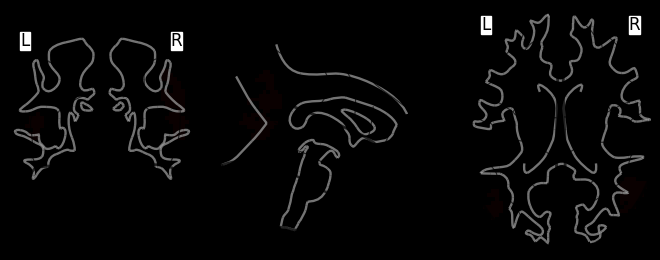

     run-5
     [0.01, 'fpr']
     [0.05, 'fpr']


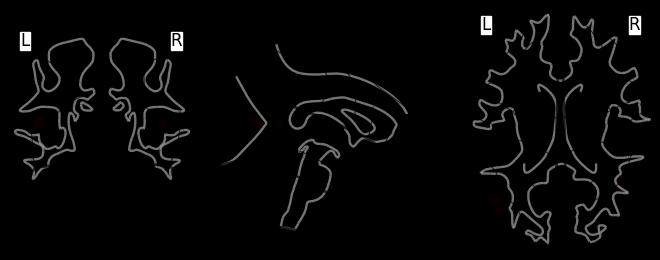

     run-6
     [0.05, 'fpr']
     [0.05, 'fpr']


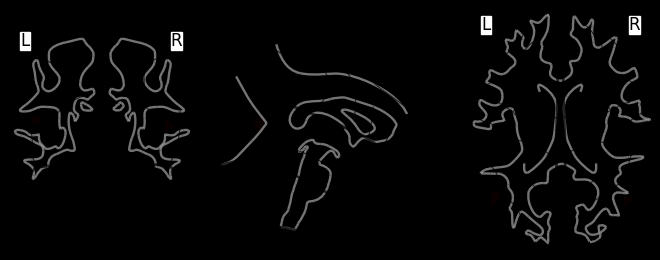

In [137]:
for sub_id in mask_collector:
    print('*************')
    print(sub_id)
    
    for task_id in mask_collector[sub_id]:
        print(' ', task_id)
        for con_id in mask_collector[sub_id][task_id]:
            print('  ',con_id)
            for rr_ in mask_collector[sub_id][task_id][con_id]:
                # if con_id in ['MotionStatic', 'CubesIris']:
                    print('    ',rr_)
                    print('    ',mask_collector[sub_id][task_id][con_id][rr_]['left_threshold'])
                    print('    ',mask_collector[sub_id][task_id][con_id][rr_]['right_threshold'])
                    plotting.plot_glass_brain(
                                     image.math_img(
                                         'a+b', 
                                         a=mask_collector[sub_id][task_id][con_id][rr_]['left_mask'], 
                                         b=mask_collector[sub_id][task_id][con_id][rr_]['right_mask']))
                    plotting.show()
                    # plt.close('all')

In [10]:
plt.close('all')

**Remove false masks**

In [ ]:
remove_from = 'run-3-5-6'
which_hemisphere = 'right'

plotting.plot_glass_brain(
                     image.math_img('a+b', a=mask_collector[remove_from]['left_mask'], b=mask_collector[remove_from]['right_mask']))

mask_collector['run-3-5-6'][which_hemisphere+'_arr'] = np.zeros(np.shape(mask_collector['run-3-5-6'][which_hemisphere+'_arr']))
mask_collector['run-3-5-6'][which_hemisphere+'_mask'] = image.new_img_like(mask_collector['run-3-5-6'][which_hemisphere+'_mask'], 
                                                                           np.zeros(np.shape(mask_collector['run-3-5-6'][which_hemisphere+'_arr'])))

plotting.plot_glass_brain(
                     image.math_img('a+b', a=mask_collector[remove_from]['left_mask'], b=mask_collector[remove_from]['right_mask']))

In [51]:
plt.close('all')

### Compute overlaps and centers

**generate list with pairs for comparison**

In [48]:
### check what is available

for sub_id in mask_collector.keys():
    print(sub_id)
    for task_id in mask_collector[sub_id].keys():
        print('\t', task_id)
        for con_id in mask_collector[sub_id][task_id]:
            print('\t\t', con_id)
        

sub-00
	 gc
		 GazeCubes
	 MTloc
		 MotionStatic
	 gic
		 GazeCubes
		 CubesIris
sub-0000
	 gic
		 GazeCubes
		 CubesIris
	 MTloc
		 MotionStatic


In [49]:
### make the dict that is used for overlap analysis

pairs_for_comparison = {}
pair_counter = 1



taskCon_pairs_of_interest = {
    'sub-00':[
        ### compare same condition among runs: 'null' overlap
        [['gc', 'GazeCubes']],
        [['gic', 'CubesIris']],
        [['gic', 'GazeCubes']],
        [['MTloc', 'MotionStatic']],
        ### compare paris of interest
        [['gic', 'CubesIris'], ['MTloc', 'MotionStatic']],
        [['gic', 'GazeCubes'], ['MTloc', 'MotionStatic']],
        [['gc', 'GazeCubes'], ['MTloc', 'MotionStatic']],
        [['gic', 'CubesIris'], ['gic', 'GazeCubes']],
        [['gic', 'CubesIris'], ['gc', 'GazeCubes']]
    ],
    'sub-0000':[
        # compare same condition among runs: 'null' overlap
        # [['eic', 'Eyes1Iris123']],
        # [['eic', 'Cubes1Iris123']],
        [['gic', 'CubesIris']],
        [['gic', 'GazeCubes']],
        [['MTloc', 'MotionStatic']],
        # compare paris of interest
        [['gic', 'CubesIris'], ['MTloc', 'MotionStatic']],
        [['gic', 'GazeCubes'], ['MTloc', 'MotionStatic']],
        [['gic', 'CubesIris'], ['gic', 'GazeCubes']]
    ]
    

}

for sub_id in taskCon_pairs_of_interest:
    
    print(sub_id)
    pairs_for_comparison[sub_id] = {}
    
    for tc_pair in taskCon_pairs_of_interest[sub_id]:
        print('\t',tc_pair)

        # ground truth pairings
        if len(tc_pair) == 1:

            if 'null' not in pairs_for_comparison[sub_id]:
                pairs_for_comparison[sub_id]['null'] = []

            task_id = tc_pair[0][0]
            con_id = tc_pair[0][1]
            #
            available_runs = list(mask_collector[sub_id][task_id][con_id])
            run_pairs = list(itertools.combinations(available_runs, 2))

            # if run sets coprise three runs make sure to exclude pairs for which more than one run are the same, i.e. remove pairs like [run-1-2-3, run-1-2-4]
            if len(run_pairs[0][0].split('-')) == 4:
                # remove those pairs that share more than one session
                at_least_two_different = []
                for ii, pp in enumerate(run_pairs):
                    p1 = pp[0].split('-')[1:]
                    p2 = pp[1].split('-')[1:]
                    num_of_same = len(np.where([itg in p2 for itg in p1])[0])
                    if num_of_same < 1:
                        at_least_two_different.append(ii)
                run_pairs = np.array(run_pairs)[at_least_two_different]

            # 
            for run_pair_ in run_pairs:
                pairs_for_comparison[sub_id]['null'].append([])
                for run_ in run_pair_:
                    pairs_for_comparison[sub_id]['null'][-1].append([task_id, con_id, run_])



        # paris of interest    
        if len(tc_pair) == 2:
            if 'target' not in pairs_for_comparison[sub_id]:
                pairs_for_comparison[sub_id]['target'] = []
            available_runs1 = list(mask_collector[sub_id][tc_pair[0][0]][tc_pair[0][1]])
            available_runs2 = list(mask_collector[sub_id][tc_pair[1][0]][tc_pair[1][1]])

            run_pairs = list(itertools.product(available_runs1, available_runs2))

            # 
            for run_pair_ in run_pairs:
                pairs_for_comparison[sub_id]['target'].append([])
                for ir_, run_ in enumerate(run_pair_):
                    pairs_for_comparison[sub_id]['target'][-1].append([tc_pair[ir_][0], tc_pair[ir_][1], run_])




sub-00
	 [['gc', 'GazeCubes']]
	 [['gic', 'CubesIris']]
	 [['gic', 'GazeCubes']]
	 [['MTloc', 'MotionStatic']]
	 [['gic', 'CubesIris'], ['MTloc', 'MotionStatic']]
	 [['gic', 'GazeCubes'], ['MTloc', 'MotionStatic']]
	 [['gc', 'GazeCubes'], ['MTloc', 'MotionStatic']]
	 [['gic', 'CubesIris'], ['gic', 'GazeCubes']]
	 [['gic', 'CubesIris'], ['gc', 'GazeCubes']]
sub-0000
	 [['gic', 'CubesIris']]
	 [['gic', 'GazeCubes']]
	 [['MTloc', 'MotionStatic']]
	 [['gic', 'CubesIris'], ['MTloc', 'MotionStatic']]
	 [['gic', 'GazeCubes'], ['MTloc', 'MotionStatic']]
	 [['gic', 'CubesIris'], ['gic', 'GazeCubes']]


In [13]:
pairs_for_comparison['sub-00']['null']

[[['gc', 'GazeCubes', 'run-1'], ['gc', 'GazeCubes', 'run-2']],
 [['gc', 'GazeCubes', 'run-1'], ['gc', 'GazeCubes', 'run-3']],
 [['gc', 'GazeCubes', 'run-2'], ['gc', 'GazeCubes', 'run-3']],
 [['gic', 'CubesIris', 'run-1'], ['gic', 'CubesIris', 'run-2']],
 [['gic', 'CubesIris', 'run-1'], ['gic', 'CubesIris', 'run-3']],
 [['gic', 'CubesIris', 'run-2'], ['gic', 'CubesIris', 'run-3']],
 [['gic', 'GazeCubes', 'run-1'], ['gic', 'GazeCubes', 'run-2']],
 [['gic', 'GazeCubes', 'run-1'], ['gic', 'GazeCubes', 'run-3']],
 [['gic', 'GazeCubes', 'run-2'], ['gic', 'GazeCubes', 'run-3']],
 [['MTloc', 'MotionStatic', 'run-1'], ['MTloc', 'MotionStatic', 'run-2']],
 [['MTloc', 'MotionStatic', 'run-1'], ['MTloc', 'MotionStatic', 'run-3']],
 [['MTloc', 'MotionStatic', 'run-1'], ['MTloc', 'MotionStatic', 'run-4']],
 [['MTloc', 'MotionStatic', 'run-1'], ['MTloc', 'MotionStatic', 'run-5']],
 [['MTloc', 'MotionStatic', 'run-1'], ['MTloc', 'MotionStatic', 'run-6']],
 [['MTloc', 'MotionStatic', 'run-1'], ['MTloc'

In [11]:
mask_collector[sub_id][pair_[0][0]][pair_[0][1]][pair_[0][2]].keys()

dict_keys(['left_arr', 'right_arr', 'left_mask', 'left_threshold', 'right_mask', 'right_threshold'])

In [62]:
ol_

[0.0]

In [63]:
or_

[84.72]

In [69]:
pairs_for_comparison

{'sub-00': {'null': [[['gc', 'GazeCubes', 'run-1'],
    ['gc', 'GazeCubes', 'run-2']],
   [['gc', 'GazeCubes', 'run-1'], ['gc', 'GazeCubes', 'run-3']],
   [['gc', 'GazeCubes', 'run-2'], ['gc', 'GazeCubes', 'run-3']],
   [['gic', 'CubesIris', 'run-1'], ['gic', 'CubesIris', 'run-2']],
   [['gic', 'CubesIris', 'run-1'], ['gic', 'CubesIris', 'run-3']],
   [['gic', 'CubesIris', 'run-2'], ['gic', 'CubesIris', 'run-3']],
   [['gic', 'GazeCubes', 'run-1'], ['gic', 'GazeCubes', 'run-2']],
   [['gic', 'GazeCubes', 'run-1'], ['gic', 'GazeCubes', 'run-3']],
   [['gic', 'GazeCubes', 'run-2'], ['gic', 'GazeCubes', 'run-3']],
   [['MTloc', 'MotionStatic', 'run-1'], ['MTloc', 'MotionStatic', 'run-2']],
   [['MTloc', 'MotionStatic', 'run-1'], ['MTloc', 'MotionStatic', 'run-3']],
   [['MTloc', 'MotionStatic', 'run-1'], ['MTloc', 'MotionStatic', 'run-4']],
   [['MTloc', 'MotionStatic', 'run-1'], ['MTloc', 'MotionStatic', 'run-5']],
   [['MTloc', 'MotionStatic', 'run-1'], ['MTloc', 'MotionStatic', 'run-6'

In [50]:
### run the overlap analysis on selected pairs

overlap_collection = {}
center_collection = {}


for sub_id in pairs_for_comparison:
    overlap_collection[sub_id] = {}
    center_collection[sub_id] = {}
    print('\n*******************')
    print(sub_id)
    
    for pair_type_ in pairs_for_comparison[sub_id]:

        overlap_collection[sub_id][pair_type_] = []#{'LH':[], 'RH':[]}
        center_collection[sub_id][pair_type_] = []
        # center_collection[pair_type_] = []#{'LH':[], 'RH':[]}

        for pair_ in pairs_for_comparison[sub_id][pair_type_]:
            print(pair_)

            overlap_collection[sub_id][pair_type_].append({
                'task1': pair_[0][0], 'task2': pair_[1][0], 'con1': pair_[0][1], 'con2': pair_[1][1],  'runs1': pair_[0][2], 'runs2': pair_[1][2], 
                'overlap': {'LH': np.NaN, 'RH': np.NaN}})
            center_collection[sub_id][pair_type_].append({
                'task1': pair_[0][0], 'task2': pair_[1][0], 'con1': pair_[0][1], 'con2': pair_[1][1],  'runs1': pair_[0][2], 'runs2': pair_[1][2], 
                'center': {'LH': np.NaN, 'RH': np.NaN}})

            task_con_dict = {
                    'tc1':
                        {
                            'pre_defined_masks':[
                                mask_collector[sub_id][pair_[0][0]][pair_[0][1]][pair_[0][2]]['left_arr'], 
                                mask_collector[sub_id][pair_[0][0]][pair_[0][1]][pair_[0][2]]['right_arr'], 
                                mask_collector[sub_id][pair_[0][0]][pair_[0][1]][pair_[0][2]]['left_mask'],
                                mask_collector[sub_id][pair_[0][0]][pair_[0][1]][pair_[0][2]]['right_mask'],
                                mask_collector[sub_id][pair_[0][0]][pair_[0][1]][pair_[0][2]]['img_name']],
                            'task':pair_[0][0], 
                            'con':pair_[0][1],
                            'runs':pair_[0][2],
                            'sign':'negative',
                            'alpha':0.05,
                            'h_control':'fdr',
                            'cluster_threshold':3,
                            'fwhm':None,
                            'mask_lbls':False # [2,5]
                        },
                    'tc2':
                        {
                            'pre_defined_masks':[
                                mask_collector[sub_id][pair_[1][0]][pair_[1][1]][pair_[1][2]]['left_arr'], 
                                mask_collector[sub_id][pair_[1][0]][pair_[1][1]][pair_[1][2]]['right_arr'], 
                                mask_collector[sub_id][pair_[1][0]][pair_[1][1]][pair_[1][2]]['left_mask'],
                                mask_collector[sub_id][pair_[1][0]][pair_[1][1]][pair_[1][2]]['right_mask'],
                                mask_collector[sub_id][pair_[1][0]][pair_[1][1]][pair_[1][2]]['img_name']],
                            'task':pair_[1][0], 
                            'con':pair_[1][1],
                            'runs':pair_[1][2],
                            'sign':'negative',
                            'alpha':0.05,
                            'h_control':'fdr',
                            'cluster_threshold':3,
                            'fwhm':None,
                            'mask_lbls':False
                        }}

            ol_, or_, cm_, _ = subjects[sub_id]['ses-com'].compute_overlap( # the specified session doesn't matter, just required to call the function
                #
                task_con_dict=task_con_dict,
                #
                cut_coords=np.arange(-3, 21, 3),
                plot_results=False,
                display_result_table=False,
                store_=False,
                plot_mask_components=False
            )

            center_collection[sub_id][pair_type_][-1]['center'] = cm_
            overlap_collection[sub_id][pair_type_][-1]['overlap']['LH'] = ol_[0]
            overlap_collection[sub_id][pair_type_][-1]['overlap']['RH'] = or_[0]

            # overlap_collection[cid]['LH'].append(ol_[0])
            # overlap_collection[cid]['RH'].append(or_[0])
            # center_collection[cid]['LH'].append(cm_['tc1']['left'])
            # center_collection[cid]['LH'].append(cm_['tc2']['left'])
            # center_collection[cid]['RH'].append(cm_['tc1']['right'])
            # center_collection[cid]['RH'].append(cm_['tc2']['right'])


*******************
sub-00
[['gc', 'GazeCubes', 'run-1'], ['gc', 'GazeCubes', 'run-2']]
[['gc', 'GazeCubes', 'run-1'], ['gc', 'GazeCubes', 'run-3']]
[['gc', 'GazeCubes', 'run-2'], ['gc', 'GazeCubes', 'run-3']]
[['gic', 'CubesIris', 'run-1'], ['gic', 'CubesIris', 'run-2']]
[['gic', 'CubesIris', 'run-1'], ['gic', 'CubesIris', 'run-3']]
[['gic', 'CubesIris', 'run-2'], ['gic', 'CubesIris', 'run-3']]
[['gic', 'GazeCubes', 'run-1'], ['gic', 'GazeCubes', 'run-2']]
[['gic', 'GazeCubes', 'run-1'], ['gic', 'GazeCubes', 'run-3']]
[['gic', 'GazeCubes', 'run-2'], ['gic', 'GazeCubes', 'run-3']]
[['MTloc', 'MotionStatic', 'run-1'], ['MTloc', 'MotionStatic', 'run-2']]
[['MTloc', 'MotionStatic', 'run-1'], ['MTloc', 'MotionStatic', 'run-3']]
[['MTloc', 'MotionStatic', 'run-1'], ['MTloc', 'MotionStatic', 'run-4']]
[['MTloc', 'MotionStatic', 'run-1'], ['MTloc', 'MotionStatic', 'run-5']]
[['MTloc', 'MotionStatic', 'run-1'], ['MTloc', 'MotionStatic', 'run-6']]
[['MTloc', 'MotionStatic', 'run-1'], ['MTloc',

### Make center dataframe

In [55]:


center_dict_reshaped = {'subject': [], 'task':[], 'con':[], 'runs':[], 'xl':[], 'yl':[], 'zl':[], 'xr':[], 'yr':[], 'zr':[]}

for sub_id in center_collection:
    
    for comp_type in center_collection[sub_id]:
        
        for pp_ in center_collection[sub_id][comp_type]:
            
            # tc1
            center_dict_reshaped['subject'].append(sub_id)
            # center_dict_reshaped['comparison_type'].append(comp_type)
            center_dict_reshaped['task'].append(pp_['task1'])
            center_dict_reshaped['con'].append(pp_['con1'])
            center_dict_reshaped['runs'].append(pp_['runs1'])
            center_dict_reshaped['xl'].append(pp_['center']['tc1']['left'][0])
            center_dict_reshaped['yl'].append(pp_['center']['tc1']['left'][1])
            center_dict_reshaped['zl'].append(pp_['center']['tc1']['left'][2])
            center_dict_reshaped['xr'].append(pp_['center']['tc1']['right'][0])
            center_dict_reshaped['yr'].append(pp_['center']['tc1']['right'][1])
            center_dict_reshaped['zr'].append(pp_['center']['tc1']['right'][2])
            
            # tc2
            center_dict_reshaped['subject'].append(sub_id)
            # center_dict_reshaped['comparison_type'].append(comp_type)
            center_dict_reshaped['task'].append(pp_['task2'])
            center_dict_reshaped['con'].append(pp_['con2'])
            center_dict_reshaped['runs'].append(pp_['runs2'])
            center_dict_reshaped['xl'].append(pp_['center']['tc2']['left'][0])
            center_dict_reshaped['yl'].append(pp_['center']['tc2']['left'][1])
            center_dict_reshaped['zl'].append(pp_['center']['tc2']['left'][2])
            center_dict_reshaped['xr'].append(pp_['center']['tc2']['right'][0])
            center_dict_reshaped['yr'].append(pp_['center']['tc2']['right'][1])
            center_dict_reshaped['zr'].append(pp_['center']['tc2']['right'][2])
        
#
center_df = pd.DataFrame(center_dict_reshaped)

In [56]:
center_df

subject task        con   runs    xl    yl   zl    xr    yr   zr
0      sub-00   gc  GazeCubes  run-1 -51.5 -69.5  5.5  47.5 -60.5 -3.5
1      sub-00   gc  GazeCubes  run-2 -48.5 -69.5  5.5  47.5 -60.5 -3.5
2      sub-00   gc  GazeCubes  run-1 -51.5 -69.5  5.5  47.5 -60.5 -3.5
3      sub-00   gc  GazeCubes  run-3 -54.5 -66.5  2.5  41.5 -60.5 -0.5
4      sub-00   gc  GazeCubes  run-2 -48.5 -69.5  5.5  47.5 -60.5 -3.5
..        ...  ...        ...    ...   ...   ...  ...   ...   ...  ...
523  sub-0000  gic  GazeCubes  run-4 -48.5 -72.5 -0.5  49.0 -66.5  5.5
524  sub-0000  gic  CubesIris  run-6 -42.5 -63.5 -0.5  53.5 -60.5 -3.5
525  sub-0000  gic  GazeCubes  run-5 -54.5 -66.5 -3.5  53.5 -60.5 -3.5
526  sub-0000  gic  CubesIris  run-6 -42.5 -63.5 -0.5  53.5 -60.5 -3.5
527  sub-0000  gic  GazeCubes  run-6 -57.5 -66.5 -6.5  44.5 -63.5 -6.5

[528 rows x 10 columns]

In [89]:
fp = '/home/marius/ownCloud/PhD/projects/scientific/gaze-motion/results/from_nilearn/roi_based_betas/gm-dat_roi-centers.csv'
center_df.to_csv(fp, sep='\t')

In [122]:
np.unique(list(center_df[(center_df.con == "CubesIris") & (center_df.subject == "sub-00")].center_left), axis=0)

array([[-51.5, -69.5,   5.5],
       [-48.5, -66.5,   5.5]])

In [107]:
for pt_ in center_df[(center_df.con == "GazeCubes") & (center_df.subject == "sub-00")].center_left:
    print(pt_[0])

-51.5
-48.5
-51.5
-54.5
-48.5
-54.5
-48.5
-48.5
-48.5
-51.5
-48.5
-51.5
-48.5
-48.5
-48.5
-48.5
-48.5
-48.5
-48.5
-48.5
-48.5
-48.5
-48.5
-48.5
-48.5
-48.5
-51.5
-51.5
-51.5
-51.5
-51.5
-51.5
-51.5
-51.5
-51.5
-51.5
-51.5
-51.5
-51.5
-51.5
-48.5
-48.5
-48.5
-48.5
-48.5
-48.5
-48.5
-54.5
-54.5
-54.5
-54.5
-54.5
-54.5
-54.5
-48.5
-48.5
-51.5
-48.5
-48.5
-51.5
-48.5
-48.5
-51.5
-51.5
-48.5
-54.5
-51.5
-48.5
-54.5
-51.5
-48.5
-54.5


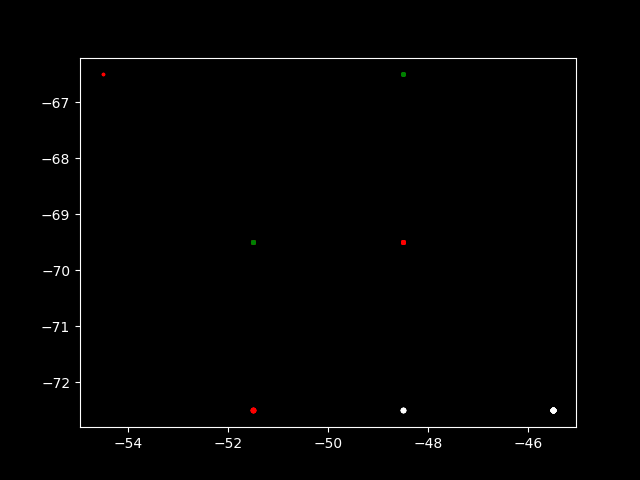

In [112]:
plt.figure()
for pt_GazeCubes, pt_MotionStatic, pt_CubesIris in zip(
                    center_df[(center_df.con == "GazeCubes") & (center_df.subject == "sub-00")].center_left,
                    center_df[(center_df.con == "MotionStatic") & (center_df.subject == "sub-00")].center_left,
                    center_df[(center_df.con == "CubesIris") & (center_df.subject == "sub-00")].center_left    ):
    
    plt.scatter(pt_GazeCubes[0], pt_GazeCubes[1], pt_GazeCubes[2], color='r')
    plt.scatter(pt_MotionStatic[0], pt_MotionStatic[1], pt_MotionStatic[2], color='w')
    plt.scatter(pt_CubesIris[0], pt_CubesIris[1], pt_CubesIris[2], color='g')
    
plt.show()

In [101]:
overlap_collection

{'sub-00': {'null': [{'task1': 'gc',
    'task2': 'gc',
    'con1': 'GazeCubes',
    'con2': 'GazeCubes',
    'runs1': 'run-1',
    'runs2': 'run-2',
    'overlap': {'LH': 71.01, 'RH': 77.08}},
   {'task1': 'gc',
    'task2': 'gc',
    'con1': 'GazeCubes',
    'con2': 'GazeCubes',
    'runs1': 'run-1',
    'runs2': 'run-3',
    'overlap': {'LH': 63.29, 'RH': 100.0}},
   {'task1': 'gc',
    'task2': 'gc',
    'con1': 'GazeCubes',
    'con2': 'GazeCubes',
    'runs1': 'run-2',
    'runs2': 'run-3',
    'overlap': {'LH': 66.46, 'RH': 100.0}},
   {'task1': 'gic',
    'task2': 'gic',
    'con1': 'CubesIris',
    'con2': 'CubesIris',
    'runs1': 'run-1',
    'runs2': 'run-2',
    'overlap': {'LH': 57.58, 'RH': 70.0}},
   {'task1': 'gic',
    'task2': 'gic',
    'con1': 'CubesIris',
    'con2': 'CubesIris',
    'runs1': 'run-1',
    'runs2': 'run-3',
    'overlap': {'LH': 68.06, 'RH': 62.79}},
   {'task1': 'gic',
    'task2': 'gic',
    'con1': 'CubesIris',
    'con2': 'CubesIris',
    'runs

In [126]:
bb

[66.39,
 66.67,
 44.44,
 45.45,
 91.92,
 45.45,
 61.34,
 64.82,
 67.68,
 70.14,
 73.61,
 38.89,
 84.85,
 91.92,
 66.67,
 56.28,
 71.36,
 46.2,
 96.97,
 79.55,
 88.37,
 92.45,
 56.16,
 81.25,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 72.73,
 63.64,
 81.4,
 81.13,
 56.16,
 93.75,
 57.58,
 82.95,
 67.44,
 98.11,
 62.07,
 81.25,
 51.52,
 56.82,
 67.44,
 73.58,
 66.67,
 81.25,
 90.48,
 76.19,
 71.43,
 52.38,
 61.9,
 0.0]

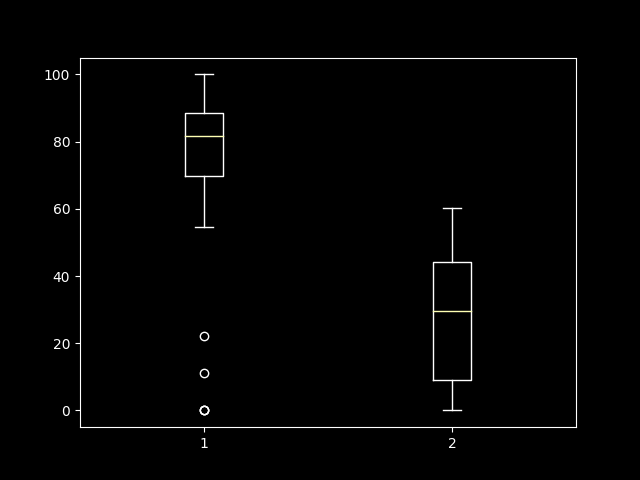

In [133]:
aa = [el['overlap']['LH'] for el in overlap_collection['sub-00']['null'] if (el['con1'] == 'MotionStatic' and el['con2'] == 'MotionStatic') or (el['con1'] == 'CubesIris' and el['con2'] == 'CubesIris')]
aa.extend([el['overlap']['LH'] for el in overlap_collection['sub-0000']['null'] if (el['con1'] == 'MotionStatic' and el['con2'] == 'MotionStatic') or (el['con1'] == 'CubesIris' and el['con2'] == 'CubesIris')])
len(aa)

bb = [el['overlap']['LH'] for el in overlap_collection['sub-00']['target'] if (el['con1'] == 'CubesIris' and el['con2'] == 'MotionStatic')]
bb.extend([el['overlap']['LH'] for el in overlap_collection['sub-0000']['target'] if (el['con1'] == 'CubesIris' and el['con2'] == 'MotionStatic')])

plt.figure()
plt.boxplot([aa, bb])
plt.show()

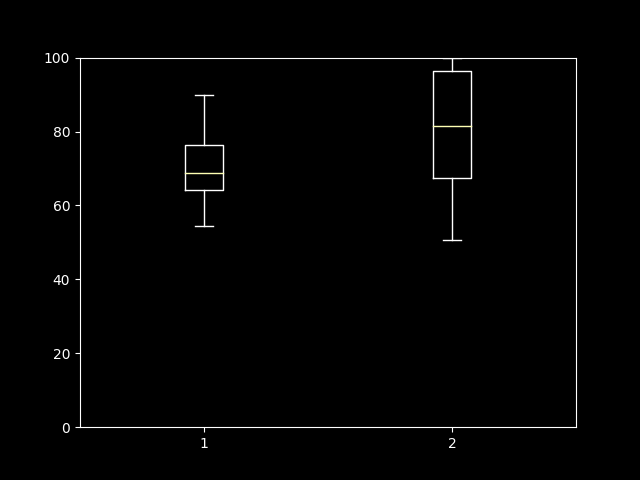

In [102]:
plt.close('all')
fig = plt.figure()
overlap_left = np.array([el['overlap']['LH'] for el in overlap_collection['sub-00']['null'] if el['con1'] == 'GazeCubes'])
overlap_right = np.array([el['overlap']['RH'] for el in overlap_collection['sub-00']['null'] if el['con1'] == 'GazeCubes'])

plt.boxplot(
    [overlap_left[~np.isnan(overlap_left)],
    overlap_right[~np.isnan(overlap_right)]])

plt.ylim(0,100);

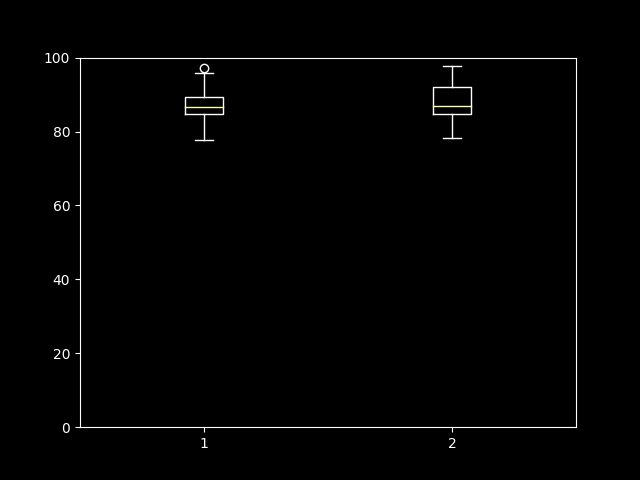

In [72]:
plt.close('all')
fig = plt.figure()
overlap_left = np.array([el['overlap']['LH'] for el in overlap_collection['sub-00']['null'] if el['con1'] == 'MotionStatic'])
overlap_right = np.array([el['overlap']['RH'] for el in overlap_collection['sub-00']['null'] if el['con1'] == 'MotionStatic'])

plt.boxplot(
    [overlap_left[~np.isnan(overlap_left)],
    overlap_right[~np.isnan(overlap_right)]])

plt.ylim(0,100);

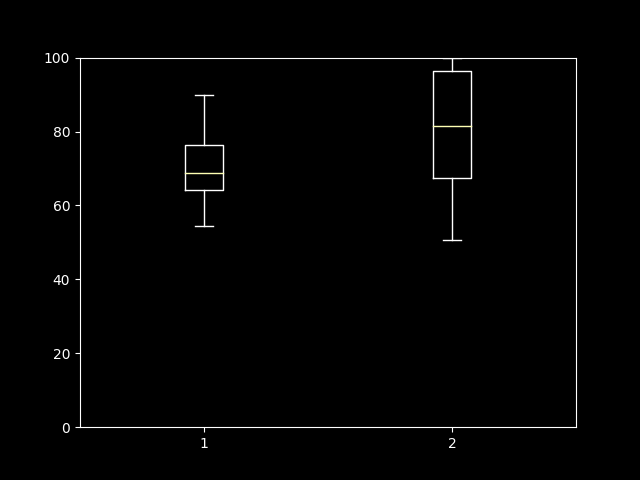

In [53]:
plt.close('all')
fig = plt.figure()
overlap_left = np.array([el['overlap']['LH'] for el in overlap_collection['sub-00']['null'] if el['con1'] == 'GazeCubes'])
overlap_right = np.array([el['overlap']['RH'] for el in overlap_collection['sub-00']['null'] if el['con1'] == 'GazeCubes'])

plt.boxplot(
    [overlap_left[~np.isnan(overlap_left)],
    overlap_right[~np.isnan(overlap_right)]])

plt.ylim(0,100);

In [78]:
overlap_collection['sub-00']['target'][0]

{'task1': 'gic',
 'task2': 'MTloc',
 'con1': 'CubesIris',
 'con2': 'MotionStatic',
 'runs1': 'run-1',
 'runs2': 'run-1',
 'overlap': {'LH': 49.59, 'RH': 48.57}}

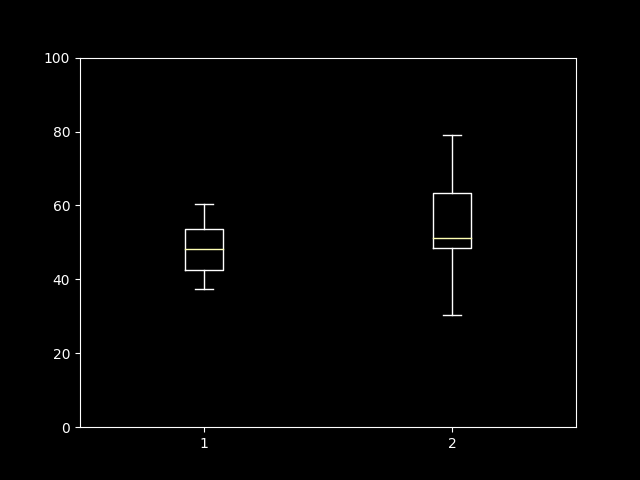

In [80]:
plt.close('all')
fig = plt.figure()
overlap_left = np.array([el['overlap']['LH'] for el in overlap_collection['sub-00']['target'] if el['con1'] == 'CubesIris' and el['con2'] == 'MotionStatic'])
overlap_right = np.array([el['overlap']['RH'] for el in overlap_collection['sub-00']['target'] if el['con1'] == 'CubesIris' and el['con2'] == 'MotionStatic'])

plt.boxplot(
    [overlap_left[~np.isnan(overlap_left)],
    overlap_right[~np.isnan(overlap_right)]])

plt.ylim(0,100);

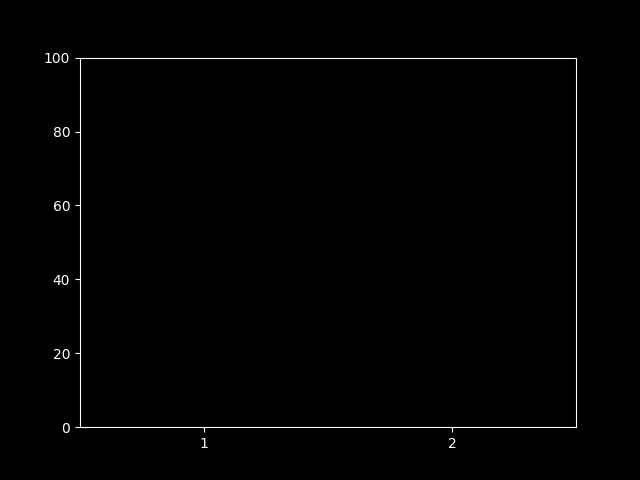

In [88]:
plt.close('all')
fig = plt.figure()
overlap_left = np.array([el['overlap']['LH'] for el in overlap_collection['sub-0000']['target'] if el['con1'] == 'GazeCubes' and el['con2'] == 'GazeIris'])
overlap_right = np.array([el['overlap']['RH'] for el in overlap_collection['sub-0000']['target'] if el['con1'] == 'GazeCubes' and el['con2'] == 'GazeIris'])

plt.boxplot(
    [overlap_left[~np.isnan(overlap_left)],
    overlap_right[~np.isnan(overlap_right)]])

plt.ylim(0,100);

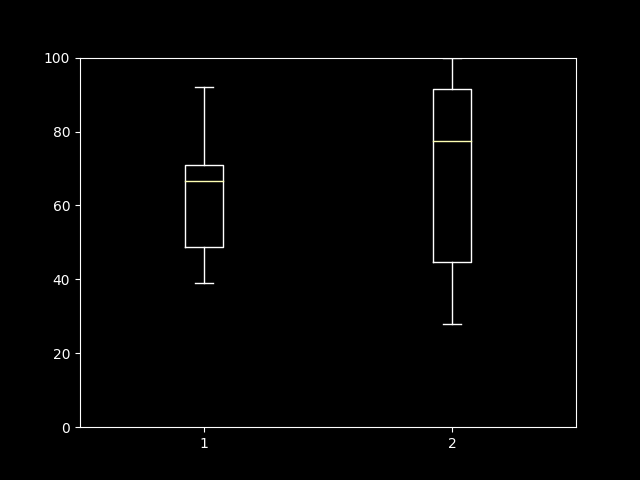

In [54]:
plt.close('all')
fig = plt.figure()
overlap_left = np.array([el['overlap']['LH'] for el in overlap_collection['sub-00']['target'] if el['con1'] == 'CubesIris' and el['con2'] == 'GazeCubes'])
overlap_right = np.array([el['overlap']['RH'] for el in overlap_collection['sub-00']['target'] if el['con1'] == 'CubesIris' and el['con2'] == 'GazeCubes'])

plt.boxplot(
    [overlap_left[~np.isnan(overlap_left)],
    overlap_right[~np.isnan(overlap_right)]])

plt.ylim(0,100);

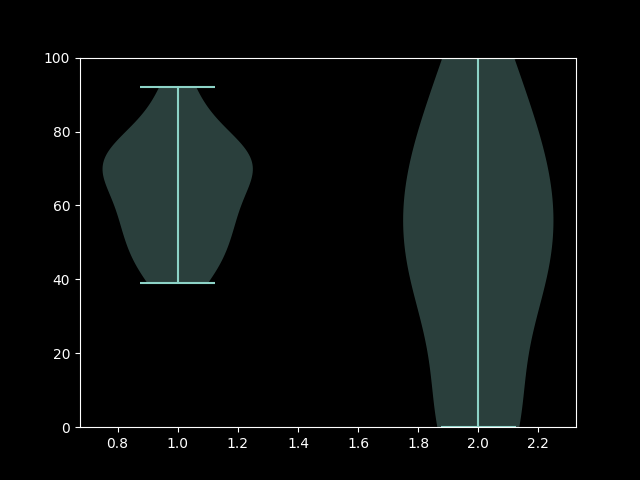

In [10]:
plt.close('all')
fig = plt.figure()
overlap_left = np.array([el['overlap']['LH'] for el in overlap_collection['sub-00']['target'] if el['con1'] == 'GazeCubes' and el['con2'] == 'CubesIris'])
overlap_right = np.array([el['overlap']['RH'] for el in overlap_collection['sub-00']['target'] if el['con1'] == 'GazeCubes' and el['con2'] == 'CubesIris'])

plt.violinplot(
    [overlap_left[~np.isnan(overlap_left)],
    overlap_right[~np.isnan(overlap_right)]])

plt.ylim(0,100);

ValueError: zero-size array to reduction operation minimum which has no identity

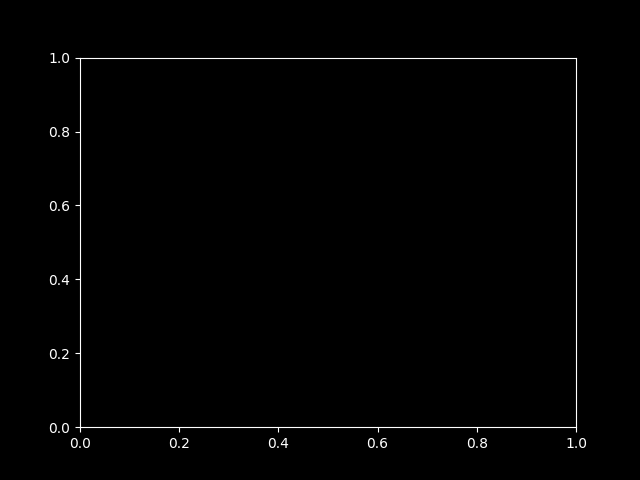

In [71]:
plt.close('all')
fig = plt.figure()
left_null = np.array([el['overlap']['LH'] for el in overlap_collection['sub-00']['null'] if el['con1'] == 'EyesCubes'])
left_target = np.array([el['overlap']['LH'] for el in overlap_collection['sub-00']['target'] if el['con1'] == 'EyesCubes' and el['con2'] == 'CubesIris'])

plt.violinplot(
    [left_null[~np.isnan(left_null)],
    left_target[~np.isnan(left_target)]])

plt.ylim(0,100);

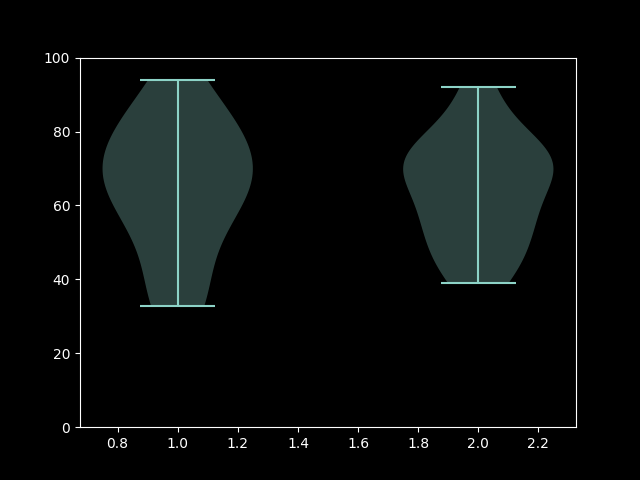

In [11]:
plt.close('all')
fig = plt.figure()
left_null = np.array([el['overlap']['LH'] for el in overlap_collection['sub-00']['null'] if el['con1'] == 'EyesCubes'])
left_target = np.array([el['overlap']['LH'] for el in overlap_collection['sub-00']['target'] if el['con1'] == 'EyesCubes' and el['con2'] == 'CubesIris'])

plt.violinplot(
    [left_null[~np.isnan(left_null)],
    left_target[~np.isnan(left_target)]])

plt.ylim(0,100);

### Make overlap dataframe

In [95]:
overlap_['runs1']+'_'+overlap_['runs2']

'run-6_run-6'

In [96]:
# reshape overlap_collection to store as dataframe

subject_type = {'sub-00': 'pilot', 'sub-0000': 'pilot'}

overlap_collector = []

for sub_id in overlap_collection:
    
    for overlap_type in overlap_collection[sub_id]:
        
        for overlap_ in overlap_collection[sub_id][overlap_type]:
        
            # left hemisphere
            overlap_collector.append([
                sub_id, 
                subject_type[sub_id], 
                overlap_['task1'], 
                overlap_['task2'],
                overlap_['runs1']+'_'+overlap_['runs2'],
                # overlap_['runs1'], 
                # overlap_['runs2'], 
                overlap_['con1'], 
                overlap_['con2'],
                list(overlap_['overlap'].keys())[0],
                overlap_['overlap'][list(overlap_['overlap'].keys())[0]],
                overlap_type+'_overlap'
            ])
            # right hemisphere
            overlap_collector.append([
                sub_id, 
                subject_type[sub_id], 
                overlap_['task1'], 
                overlap_['task2'], 
                overlap_['runs1']+'_'+overlap_['runs2'],
                # overlap_['runs1'], 
                # overlap_['runs2'], 
                overlap_['con1'], 
                overlap_['con2'],
                list(overlap_['overlap'].keys())[1],
                overlap_['overlap'][list(overlap_['overlap'].keys())[1]],
                overlap_type+'_overlap'
            ])
            
overlap_df = pd.DataFrame(overlap_collector, columns=['participant', 'subject_type', 'task1', 'task2', 'runs', 'roi1', 'roi2', 'hemisphere', 'overlap', 'overlap_type'])


In [98]:
fp = '/home/marius/ownCloud/PhD/projects/scientific/gaze-motion/results/from_nilearn/roi_based_betas/gm-dat_roi-overlaps.csv'
overlap_df.to_csv(fp, sep='\t')

In [97]:
overlap_df

participant subject_type task1 task2         runs       roi1       roi2  \
0        sub-00        pilot    gc    gc  run-1_run-2  GazeCubes  GazeCubes   
1        sub-00        pilot    gc    gc  run-1_run-2  GazeCubes  GazeCubes   
2        sub-00        pilot    gc    gc  run-1_run-3  GazeCubes  GazeCubes   
3        sub-00        pilot    gc    gc  run-1_run-3  GazeCubes  GazeCubes   
4        sub-00        pilot    gc    gc  run-2_run-3  GazeCubes  GazeCubes   
..          ...          ...   ...   ...          ...        ...        ...   
523    sub-0000        pilot   gic   gic  run-6_run-4  CubesIris  GazeCubes   
524    sub-0000        pilot   gic   gic  run-6_run-5  CubesIris  GazeCubes   
525    sub-0000        pilot   gic   gic  run-6_run-5  CubesIris  GazeCubes   
526    sub-0000        pilot   gic   gic  run-6_run-6  CubesIris  GazeCubes   
527    sub-0000        pilot   gic   gic  run-6_run-6  CubesIris  GazeCubes   

    hemisphere  overlap    overlap_type  
0           LH    71.01    null_overlap  
1           RH    77.08    null_overlap  
2           LH    63.29    null_overlap  
3           RH   100.00    null_overlap  
4           LH    66.46    null_overlap  
..         ...      ...             ...  
523         RH    50.00  target_overlap  
524         LH    61.90  target_overlap  
525         RH    71.56  target_overlap  
526         LH     0.00  target_overlap  
527         RH    84.72  target_overlap  

[528 rows x 10 columns]